# Postings Release Analysis: BGI vs Lightcast Comparison

In [1]:
# Snowflake connection setup
import snowflake.connector as snow
import pandas as pd
import os
import importlib.util
import matplotlib.pyplot as plt

# Load credentials from config file
config_file_path = r"C:\Users\JuliaNania\OneDrive - Burning Glass Institute\Documents\Python\config.py"
spec = importlib.util.spec_from_file_location("config", config_file_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

# Establish connection
conn = snow.connect(
    user=config.credentials['USERNAME'],
    password=config.credentials['PASSWORD'],
    account='PCA67849',
    warehouse=config.credentials['WAREHOUSE'],
    database='PROJECT_DATA'
)
print("Connected to Snowflake")

Connected to Snowflake


In [2]:
# Helper function to run queries
def run_query(query):
    return pd.read_sql(query, conn)

## 1. Monthly Posting Counts Comparison
Comparing monthly job posting volumes between BGI and Lightcast

In [47]:
# Monthly counts: JOLTS, Lightcast, and BGI (2015–May 2025)
import plotly.graph_objects as go

# --- JOLTS: load from Excel (wide format: rows=years, cols=months), values in thousands ---
jolts_path = r"C:\Users\JuliaNania\OneDrive - Burning Glass Institute\Documents\GitHub\release_comparisons\jolts_total_nonfarm_monthly_jobopenings.xlsx"
jolts_raw = pd.read_excel(jolts_path, sheet_name='Sheet1')
year_col = jolts_raw.columns[0]
month_cols = jolts_raw.columns[1:]

jolts_long = jolts_raw.melt(id_vars=year_col, value_vars=month_cols,
                            var_name='MONTH_NAME', value_name='POSTING_COUNT')
jolts_long.rename(columns={year_col: 'YEAR'}, inplace=True)

# Drop metadata rows where YEAR is not numeric (e.g. "Original Data Value")
jolts_long['YEAR'] = pd.to_numeric(jolts_long['YEAR'], errors='coerce')
jolts_long = jolts_long.dropna(subset=['YEAR'])

# Map month names to numbers
month_map = {m: i for i, m in enumerate(
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 1)}
jolts_long['MONTH_NUM'] = jolts_long['MONTH_NAME'].map(month_map)
jolts_long['MONTH'] = pd.to_datetime(
    jolts_long['YEAR'].astype(int).astype(str) + '-' +
    jolts_long['MONTH_NUM'].astype(int).astype(str) + '-01', errors='coerce')
jolts_long = jolts_long.dropna(subset=['MONTH', 'POSTING_COUNT'])
jolts_long['POSTING_COUNT'] = jolts_long['POSTING_COUNT'] * 1000  # JOLTS reports in thousands
jolts_long = jolts_long[['MONTH', 'POSTING_COUNT']].sort_values('MONTH')
jolts_long['SOURCE'] = 'JOLTS'

# --- Lightcast monthly counts ---
lc_monthly_query = """
SELECT 
    DATE_TRUNC('month', POSTED) AS MONTH,
    COUNT(*) AS POSTING_COUNT
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE POSTED >= '2015-01-01' AND POSTED < '2025-12-01'
GROUP BY 1
ORDER BY 1
"""
lc_monthly = run_query(lc_monthly_query)
lc_monthly['SOURCE'] = 'Lightcast'

# --- BGI v1 monthly counts ---
bgi_monthly_query = """
SELECT 
    DATE_TRUNC('month', POST_DATE) AS MONTH,
    COUNT(*) AS POSTING_COUNT
FROM revelio_clean.bgi_2026_02.bgi_postings
WHERE BGI_COUNTRY = 'United States'
  AND POST_DATE >= '2015-01-01' AND POST_DATE < '2025-12-01'
GROUP BY 1
ORDER BY 1
"""
bgi_monthly = run_query(bgi_monthly_query)
bgi_monthly['SOURCE'] = 'BGI v1'

# --- Filter JOLTS to same window ---
jolts_long = jolts_long[(jolts_long['MONTH'] >= '2015-01-01') & (jolts_long['MONTH'] < '2025-06-01')]

# --- Combine all three sources and pivot to wide format ---
all_monthly = pd.concat([jolts_long, lc_monthly, bgi_monthly], ignore_index=True)
all_monthly['MONTH'] = pd.to_datetime(all_monthly['MONTH'])
all_monthly_wide = all_monthly.pivot(index='MONTH', columns='SOURCE', values='POSTING_COUNT').reset_index()
all_monthly_wide.columns.name = None
all_monthly_wide = all_monthly_wide[['MONTH', 'JOLTS', 'Lightcast', 'BGI v1']]
display(all_monthly_wide)

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_8128\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_8128\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,MONTH,JOLTS,Lightcast,BGI v1
0,2015-01-01,5344000.0,1857140.0,677.0
1,2015-02-01,5466000.0,1560708.0,811.0
2,2015-03-01,5210000.0,1932596.0,6490.0
3,2015-04-01,5598000.0,1994935.0,1744.0
4,2015-05-01,5563000.0,2286546.0,1586.0
...,...,...,...,...
126,2025-07-01,NaN,3916272.0,7932047.0
127,2025-08-01,NaN,3307022.0,8099495.0
128,2025-09-01,NaN,3561486.0,7326229.0
129,2025-10-01,NaN,3561893.0,7160145.0


In [48]:
# Interactive line chart: JOLTS vs Lightcast vs BGI v1 monthly counts
fig = go.Figure()
colors = {'JOLTS': '#C22036', 'Lightcast': '#A44914', 'BGI v1': '#03497A'}

for source, color in colors.items():
    subset = all_monthly[all_monthly['SOURCE'] == source].sort_values('MONTH')
    fig.add_trace(go.Scatter(
        x=subset['MONTH'], y=subset['POSTING_COUNT'] / 1e6,
        mode='lines', name=source,
        line=dict(color=color, width=2)
    ))

fig.update_layout(
    title=dict(text='Monthly US Job Openings: JOLTS vs Lightcast vs BGI v1 (2015–May 2025)',
               x=0.5, font=dict(family='Verdana')),
    xaxis=dict(title='Month', tickfont=dict(family='Verdana')),
    yaxis=dict(title='Count (Millions)', tickformat=',.1f',
               gridcolor='lightgray', tickfont=dict(family='Verdana')),
    plot_bgcolor='white',
    font=dict(family='Verdana'),
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
    annotations=[dict(
        text='Source: BGI analysis of BLS JOLTS, Lightcast job postings',
        xref='paper', yref='paper', x=1, y=-0.12,
        showarrow=False, font=dict(size=10, family='Verdana')
    )]
)
fig.show()

## 2. Salary Analysis
Comprehensive salary comparison between BGI and Lightcast

### 2.1 Salary Key Stats Comparison
Comparing min, max, average, and median salary_min between BGI and Lightcast

In [38]:
# Salary stats: Lightcast (salary_from = salary_min)
lc_salary_query = """
SELECT 
    'Lightcast' AS SOURCE,
    MIN(SALARY_FROM) AS MIN_SALARY_MIN,
    MAX(SALARY_FROM) AS MAX_SALARY_MIN,
    AVG(SALARY_FROM) AS AVG_SALARY_MIN,
    MEDIAN(SALARY_FROM) AS MEDIAN_SALARY_MIN,
    COUNT(*) AS N_POSTINGS_WITH_SALARY
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE SALARY_FROM IS NOT NULL AND SALARY_FROM > 0
"""
lc_salary = run_query(lc_salary_query)
display(lc_salary)

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_8128\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,SOURCE,MIN_SALARY_MIN,MAX_SALARY_MIN,AVG_SALARY_MIN,MEDIAN_SALARY_MIN,N_POSTINGS_WITH_SALARY
0,Lightcast,9601,999998,55475.422084,41600.0,134782160


In [39]:
# Salary stats: BGI (convert hourly to yearly if salary_per != 'year')
bgi_salary_query = """
SELECT 
    'BGI' AS SOURCE,
    MIN(YEARLY_SALARY_MIN) AS MIN_SALARY_MIN,
    MAX(YEARLY_SALARY_MIN) AS MAX_SALARY_MIN,
    AVG(YEARLY_SALARY_MIN) AS AVG_SALARY_MIN,
    MEDIAN(YEARLY_SALARY_MIN) AS MEDIAN_SALARY_MIN,
    COUNT(*) AS N_POSTINGS_WITH_SALARY
FROM (
    SELECT 
        CASE 
            WHEN LOWER(SALARY_PER) = 'year' THEN PARSED_SALARY_MIN
            WHEN LOWER(SALARY_PER) = 'hour' THEN PARSED_SALARY_MIN * 2000
            WHEN LOWER(SALARY_PER) = 'week' THEN PARSED_SALARY_MIN * 50
            WHEN LOWER(SALARY_PER) = 'day' THEN PARSED_SALARY_MIN * 260 
            WHEN LOWER(SALARY_PER) = 'month' THEN PARSED_SALARY_MIN * 12
            WHEN LOWER(SALARY_PER) = 'piece' THEN NULL 
            ELSE PARSED_SALARY_MIN
        END AS YEARLY_SALARY_MIN
    FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
        INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
    WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
      AND BGI_COUNTRY = 'United States'
)
"""
bgi_salary = run_query(bgi_salary_query)
display(bgi_salary)

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_8128\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,SOURCE,MIN_SALARY_MIN,MAX_SALARY_MIN,AVG_SALARY_MIN,MEDIAN_SALARY_MIN,N_POSTINGS_WITH_SALARY
0,BGI,0.000001,1.500002e+50,2.441717e+41,54280.0,614505599


In [40]:
# Combined salary comparison table
salary_comparison = pd.concat([lc_salary, bgi_salary], ignore_index=True)
display(salary_comparison.style.format('{:,.2f}', subset=['MIN_SALARY_MIN', 'MAX_SALARY_MIN', 'AVG_SALARY_MIN', 'MEDIAN_SALARY_MIN']))

,SOURCE,MIN_SALARY_MIN,MAX_SALARY_MIN,AVG_SALARY_MIN,MEDIAN_SALARY_MIN,N_POSTINGS_WITH_SALARY
0,Lightcast,"9,601.00","999,998.00","55,475.42","41,600.00",134782160
1,BGI,0.00,"150,000,188,000,315,004,833,395,410,836,932,845,428,953,957,007,360.00","244,171,686,321,658,839,900,495,716,805,094,185,893,888.00","54,280.00",614505599


### 2.2 Salary Distribution
Distribution of minimum salary (annualized)

In [41]:
# Query salary distribution in $10k buckets up to $200k + one ">200k" bucket
# Filtered to year 2025 only
lc_dist_query = """
SELECT 
    CASE 
        WHEN SALARY_FROM > 200000 THEN 210000
        ELSE FLOOR(SALARY_FROM / 10000) * 10000 
    END AS SALARY_BUCKET,
    COUNT(*) AS COUNT
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE SALARY_FROM IS NOT NULL AND SALARY_FROM > 0
  AND YEAR(POSTED) = 2025
GROUP BY 1
ORDER BY 1
"""
lc_dist = run_query(lc_dist_query)

# Get total LC postings with salary for percentage calculation (2025 only)
lc_total = run_query("""
SELECT COUNT(*) AS TOTAL FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE SALARY_FROM IS NOT NULL AND SALARY_FROM > 0
  AND YEAR(POSTED) = 2025
""")['TOTAL'].iloc[0]

bgi_dist_query = """
SELECT 
    CASE 
        WHEN YEARLY_SALARY_MIN > 200000 THEN 210000
        ELSE FLOOR(YEARLY_SALARY_MIN / 10000) * 10000 
    END AS SALARY_BUCKET,
    COUNT(*) AS COUNT
FROM (
    SELECT 
        CASE 
            WHEN LOWER(SALARY_PER) = 'year' THEN PARSED_SALARY_MIN
            WHEN LOWER(SALARY_PER) = 'hour' THEN PARSED_SALARY_MIN * 2000
            WHEN LOWER(SALARY_PER) = 'week' THEN PARSED_SALARY_MIN * 50
            WHEN LOWER(SALARY_PER) = 'day' THEN PARSED_SALARY_MIN * 260 
            WHEN LOWER(SALARY_PER) = 'month' THEN PARSED_SALARY_MIN * 12
            WHEN LOWER(SALARY_PER) = 'piece' THEN NULL
            ELSE PARSED_SALARY_MIN
        END AS YEARLY_SALARY_MIN
    FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
        INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
    WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
      AND BGI_COUNTRY = 'United States'
      AND YEAR(p.POST_DATE) = 2025
)
GROUP BY 1
ORDER BY 1
"""
bgi_dist = run_query(bgi_dist_query)

# Get total BGI postings with salary for percentage calculation (2025 only)
bgi_total = run_query("""
SELECT COUNT(*) AS TOTAL FROM (
    SELECT 1
    FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
        INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
    WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
      AND BGI_COUNTRY = 'United States'
      AND YEAR(p.POST_DATE) = 2025
)
""")['TOTAL'].iloc[0]

# Convert to percentages based on full 2025 dataset
lc_dist['PCT'] = lc_dist['COUNT'] / lc_total * 100
bgi_dist['PCT'] = bgi_dist['COUNT'] / bgi_total * 100

# Merge to align buckets for charting
salary_dist = lc_dist[['SALARY_BUCKET', 'PCT']].rename(columns={'PCT': 'LC_PCT'}).merge(
    bgi_dist[['SALARY_BUCKET', 'PCT']].rename(columns={'PCT': 'BGI_PCT'}),
    on='SALARY_BUCKET', how='outer'
).fillna(0).sort_values('SALARY_BUCKET')

print(f"LC total postings with salary (2025): {lc_total:,}")
print(f"BGI total postings with salary (2025): {bgi_total:,}")

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_8128\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



LC total postings with salary (2025): 20,400,267
BGI total postings with salary (2025): 120,660,750


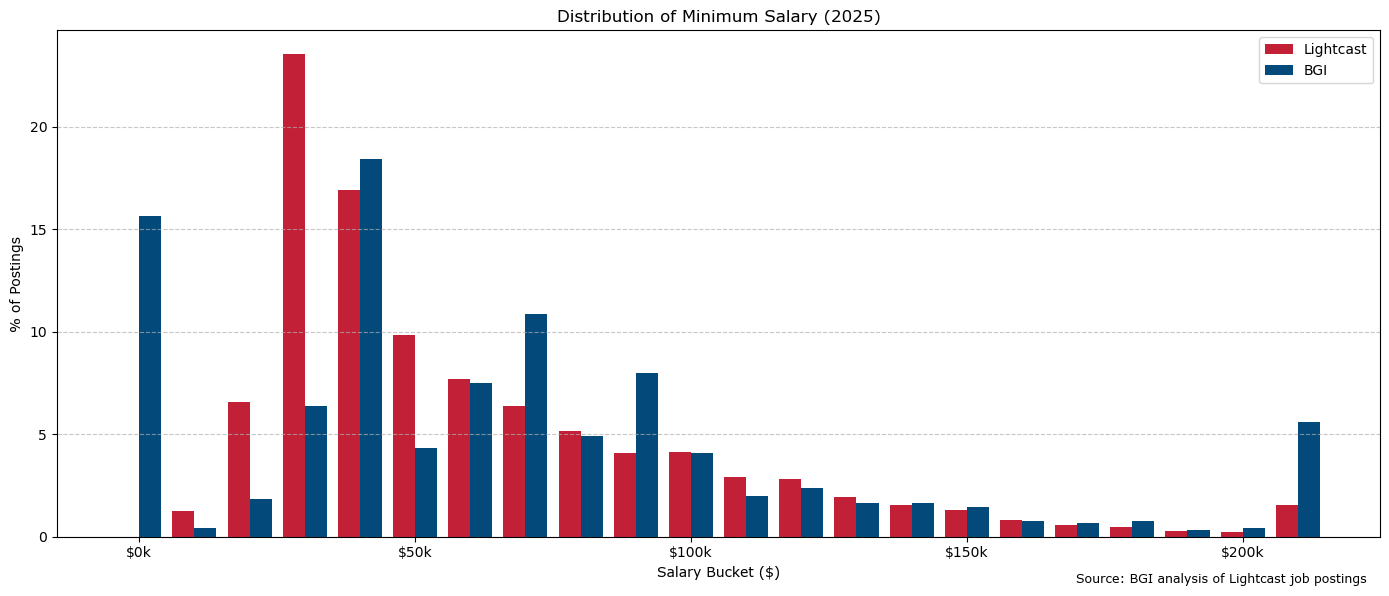

In [52]:
# Chart: Salary distribution with >200k bucket (2025 only)
fig, ax = plt.subplots(figsize=(14, 6))
x = salary_dist['SALARY_BUCKET']
width = 4000

ax.bar(x - width/2, salary_dist['LC_PCT'], width, label='Lightcast', color='#C22036')
ax.bar(x + width/2, salary_dist['BGI_PCT'], width, label='BGI', color='#03497A')
ax.set_xlabel('Salary Bucket ($)', fontname='Verdana')
ax.set_ylabel('% of Postings', fontname='Verdana')
ax.set_title('Distribution of Minimum Salary (2025)', fontname='Verdana')
ax.legend(loc='upper right')

# Custom formatter to show ">200k" for the 210000 bucket
def format_salary(x, _):
    if x == 210000:
        return '>$200k'
    return f'${x/1000:.0f}k'
ax.xaxis.set_major_formatter(plt.FuncFormatter(format_salary))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}'))
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
fig.text(0.98, 0.02, 'Source: BGI analysis of Lightcast job postings', 
         ha='right', fontsize=9, fontname='Verdana')
plt.tight_layout()
plt.show()

### 2.3 Salary Outliers
Examples of very high and very low salary values

In [42]:
# Examples of very high salary_min values with original SALARY_TEXT
high_salary_query = """
SELECT 
    sal.DESC_ID,
    sal.SALARY_TEXT,
    sal.PARSED_SALARY_MIN,
    sal.SALARY_PER,
    CASE 
        WHEN LOWER(SALARY_PER) = 'year' THEN PARSED_SALARY_MIN
        WHEN LOWER(SALARY_PER) = 'hour' THEN PARSED_SALARY_MIN * 2000
        WHEN LOWER(SALARY_PER) = 'week' THEN PARSED_SALARY_MIN * 50
        WHEN LOWER(SALARY_PER) = 'day' THEN PARSED_SALARY_MIN * 260 
        WHEN LOWER(SALARY_PER) = 'month' THEN PARSED_SALARY_MIN * 12
        ELSE PARSED_SALARY_MIN
    END AS YEARLY_SALARY_MIN
FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
    INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
  AND BGI_COUNTRY = 'United States'
ORDER BY YEARLY_SALARY_MIN DESC
LIMIT 20
"""
high_salary_examples = run_query(high_salary_query)
print("=== Very High Salary Examples ===")
display(high_salary_examples)

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_9148\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


=== Very High Salary Examples ===


,DESC_ID,SALARY_TEXT,PARSED_SALARY_MIN,SALARY_PER,YEARLY_SALARY_MIN
0,034e1e6159a100649eb84fe66c480475,Grammarly offers all team members competitive ...,1.500002e+50,year,1.500002e+50
1,5d652b5cf85c666cc7c41b73a3655b30,"CB Neptune Holdings, LLC has immediate availab...",9.506095e+44,NA,9.506095e+44
2,48923ef8721d5af45354bc7e3cb55d54,"Pay is based upon experience and, as establish...",5.180555e+44,NA,5.180555e+44
3,ea122cd92547212a93e52fb75124931e,2023-24 School Year Prior Years of Experience ...,3.367370e+44,NA,3.367370e+44
4,bd9df8a5cc484ace50415ec04c2af1ff,Pay based upon experience and as established b...,3.367370e+44,NA,3.367370e+44
5,f03e4e2abb902092fa79fd043fd657c6,Pay based upon experience and as established b...,2.357269e+44,NA,2.357269e+44
6,3a12696ca4714fa2482fc68f3de2c827,Pay based upon experience and as established b...,2.357269e+44,NA,2.357269e+44
7,a54c8c4d7755a1a8119c7ee80877618c,Pay based upon experience and as established b...,2.357269e+44,NA,2.357269e+44
8,6ad30c488020d8510429dd36e38f0055,Pay based upon experience and as established b...,2.357269e+44,NA,2.357269e+44
9,aae294ac02c47e7d2c66ec9532336ee2,Grammarly offers all team members competitive ...,1.570002e+44,year,1.570002e+44


In [43]:
# Examples of very low salary_min values with original SALARY_TEXT
low_salary_query = """
SELECT 
    sal.DESC_ID,
    sal.SALARY_TEXT,
    sal.PARSED_SALARY_MIN,
    sal.SALARY_PER,
    CASE 
        WHEN LOWER(SALARY_PER) = 'year' THEN PARSED_SALARY_MIN
        WHEN LOWER(SALARY_PER) = 'hour' THEN PARSED_SALARY_MIN * 2000
        WHEN LOWER(SALARY_PER) = 'week' THEN PARSED_SALARY_MIN * 50
        WHEN LOWER(SALARY_PER) = 'day' THEN PARSED_SALARY_MIN * 260 
        WHEN LOWER(SALARY_PER) = 'month' THEN PARSED_SALARY_MIN * 12
        ELSE PARSED_SALARY_MIN
    END AS YEARLY_SALARY_MIN
FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
    INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
  AND BGI_COUNTRY = 'United States'
ORDER BY YEARLY_SALARY_MIN ASC
LIMIT 20
"""
low_salary_examples = run_query(low_salary_query)
print("=== Very Low Salary Examples ===")
display(low_salary_examples)

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_9148\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


=== Very Low Salary Examples ===


,DESC_ID,SALARY_TEXT,PARSED_SALARY_MIN,SALARY_PER,YEARLY_SALARY_MIN
0,6b4f447a2ad21bb465742939a03645a0,"Overview: 0.000001- FTE, contingent position: ...",0.000001,NA,0.000001
1,50cb97409c1625c5b5a4461042244857,New employees are paid only by direct deposit ...,0.000005,NA,0.000005
2,50cb97409c1625c5b5a4461042244857,New employees are paid only by direct deposit ...,0.000005,NA,0.000005
3,f783ac71f9bc35ef7c75c2b66cb55842,Job Category: Academic/Research Position Type:...,0.000100,NA,0.000100
4,bcf5c3b0526a619f257df6622590fda0,"- Job Category: Academic/Research, - Job Speci...",0.000100,NA,0.000100
5,6c919728b92f1888833df3a5903f41d5,Type: Full-time Shift Length: 8-hour shift Shi...,0.000100,NA,0.000100
6,18bb75b0b0b57c93596748e0efe9df66,**Position Type:** Full-time. **Shift Length:*...,0.000100,NA,0.000100
7,75c0ac45809ade6533e69ad8756ac646,Working Title: Visiting Postdoctoral Scientist...,0.000100,NA,0.000100
8,805a0ea9e018393f5643d8acfba6fb19,---* Position Type: Full-time\n ---* Shift Len...,0.000100,NA,0.000100
9,f13ad9cf4056be3e508cc03d6aa1fbc5,Category: Students/Interns/Trainees Position T...,0.000100,NA,0.000100


### 2.4 Median Min Salary by SOC 2 Occupation
Comparing median minimum salary across broad occupation categories

In [43]:
# Median min salary by SOC 2 occupation - Lightcast
lc_soc2_query = """
SELECT 
    SOC_2_NAME AS SOC2,
    MEDIAN(SALARY_FROM) AS MEDIAN_SALARY_MIN,
    COUNT(*) AS N_POSTINGS
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE SALARY_FROM IS NOT NULL AND SALARY_FROM > 0
  AND YEAR(POSTED) = 2025
  AND SOC_2_NAME IS NOT NULL
GROUP BY 1
ORDER BY 2 DESC
"""
lc_soc2 = run_query(lc_soc2_query)
lc_soc2['SOURCE'] = 'Lightcast'

# Median min salary by SOC 2 occupation - BGI
bgi_soc2_query = """
SELECT 
    lu.BGI_SOC2_NAME AS SOC2,
    MEDIAN(YEARLY_SALARY_MIN) AS MEDIAN_SALARY_MIN,
    COUNT(*) AS N_POSTINGS
FROM (
    SELECT 
        p.ONET_CODE,
        CASE 
            WHEN LOWER(SALARY_PER) = 'year' THEN PARSED_SALARY_MIN
            WHEN LOWER(SALARY_PER) = 'hour' THEN PARSED_SALARY_MIN * 2000
            WHEN LOWER(SALARY_PER) = 'week' THEN PARSED_SALARY_MIN * 50
            WHEN LOWER(SALARY_PER) = 'day' THEN PARSED_SALARY_MIN * 260 
            WHEN LOWER(SALARY_PER) = 'month' THEN PARSED_SALARY_MIN * 12
            WHEN LOWER(SALARY_PER) = 'piece' THEN NULL
            ELSE PARSED_SALARY_MIN
        END AS YEARLY_SALARY_MIN
    FROM REVELIO_CLEAN.V1.BGI_POSTINGS p 
        INNER JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
    WHERE PARSED_SALARY_MIN IS NOT NULL AND PARSED_SALARY_MIN > 0
      AND BGI_COUNTRY = 'United States'
      AND YEAR(p.POST_DATE) = 2025
) sub
INNER JOIN temporary_data.jnania.onet_soc_lookup lu ON lu.bgi_onet = sub.ONET_CODE
WHERE YEARLY_SALARY_MIN IS NOT NULL AND YEARLY_SALARY_MIN <= 500000
GROUP BY 1
ORDER BY 2 DESC
"""
bgi_soc2 = run_query(bgi_soc2_query)
bgi_soc2['SOURCE'] = 'BGI'

# Merge for comparison
soc2_comparison = lc_soc2[['SOC2', 'MEDIAN_SALARY_MIN']].rename(columns={'MEDIAN_SALARY_MIN': 'LC_MEDIAN'}).merge(
    bgi_soc2[['SOC2', 'MEDIAN_SALARY_MIN']].rename(columns={'MEDIAN_SALARY_MIN': 'BGI_MEDIAN'}),
    on='SOC2', how='outer'
).fillna(0).sort_values('LC_MEDIAN', ascending=True)

display(soc2_comparison)

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_8128\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_8128\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,SOC2,LC_MEDIAN,BGI_MEDIAN
9,Food Preparation and Serving Related Occupations,33280.0,33000.0
2,Building and Grounds Cleaning and Maintenance ...,35360.0,32000.0
8,"Farming, Fishing, and Forestry Occupations",37565.0,41540.0
11,Healthcare Support Occupations,37898.0,40000.0
18,Personal Care and Service Occupations,39000.0,43825.0
21,Sales and Related Occupations,40040.0,50000.0
20,Protective Service Occupations,40332.0,48000.0
1,"Arts, Design, Entertainment, Sports, and Media...",41600.0,40000.0
19,Production Occupations,41600.0,48000.0
22,Transportation and Material Moving Occupations,41600.0,50200.0


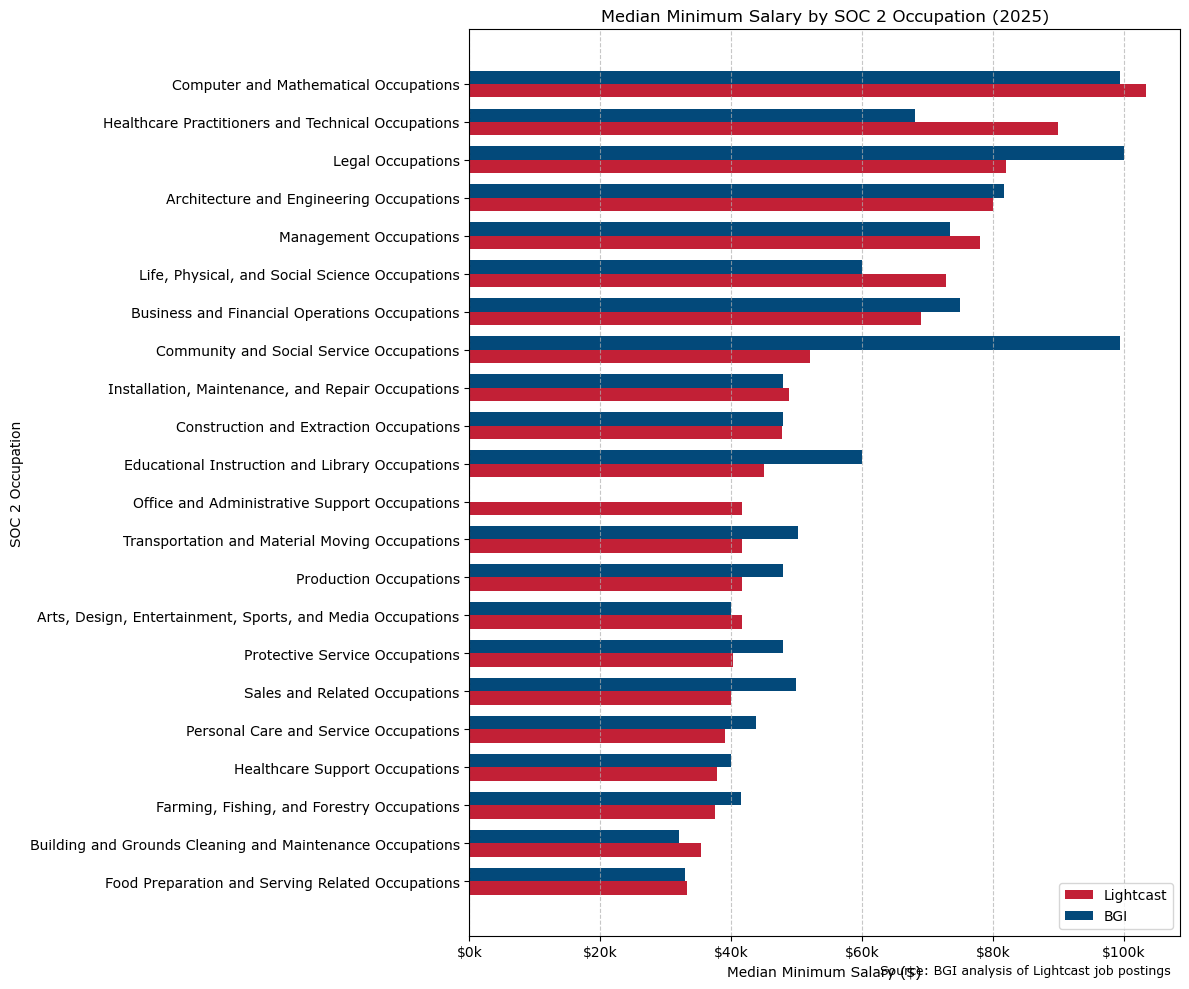

In [ ]:
# Horizontal bar chart: Median min salary by SOC 2 occupation
import numpy as np

# Filter out military and unclassified occupations
soc2_chart = soc2_comparison[~soc2_comparison['SOC2'].str.lower().str.contains('military|unclassified', na=False)]

fig, ax = plt.subplots(figsize=(12, 10))
y = np.arange(len(soc2_chart))
height = 0.35

ax.barh(y - height/2, soc2_chart['LC_MEDIAN'], height, label='Lightcast', color='#C22036')
ax.barh(y + height/2, soc2_chart['BGI_MEDIAN'], height, label='BGI', color='#03497A')

ax.set_xlabel('Median Minimum Salary ($)', fontname='Verdana')
ax.set_ylabel('SOC 2 Occupation', fontname='Verdana')
ax.set_title('Median Minimum Salary by SOC 2 Occupation (2025)', fontname='Verdana')
ax.set_yticks(y)
ax.set_yticklabels(soc2_chart['SOC2'], fontname='Verdana', fontsize=10)
ax.legend(loc='lower right')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

fig.text(0.98, 0.02, 'Source: BGI analysis of Lightcast job postings', 
         ha='right', fontsize=9, fontname='Verdana')
plt.tight_layout()
plt.show()

In [45]:
# Analyze similarity between LC and BGI median salaries by SOC 2
from scipy import stats

# Use filtered data (exclude military/unclassified and rows with 0 values)
soc2_valid = soc2_chart[(soc2_chart['LC_MEDIAN'] > 0) & (soc2_chart['BGI_MEDIAN'] > 0)].copy()

# Calculate difference metrics
soc2_valid['DIFF'] = soc2_valid['LC_MEDIAN'] - soc2_valid['BGI_MEDIAN']
soc2_valid['ABS_DIFF'] = soc2_valid['DIFF'].abs()
soc2_valid['PCT_DIFF'] = (soc2_valid['DIFF'] / soc2_valid['LC_MEDIAN']) * 100

# Correlation
correlation, p_value = stats.pearsonr(soc2_valid['LC_MEDIAN'], soc2_valid['BGI_MEDIAN'])

# Summary statistics
print("=== Similarity Analysis: Median Min Salary by SOC 2 ===\n")
print(f"Number of SOC 2 categories compared: {len(soc2_valid)}")
print(f"\nCorrelation (Pearson r): {correlation:.3f} (p-value: {p_value:.4f})")
print(f"\nMean absolute difference: ${soc2_valid['ABS_DIFF'].mean():,.0f}")
print(f"Median absolute difference: ${soc2_valid['ABS_DIFF'].median():,.0f}")
print(f"\nMean % difference (LC vs BGI): {soc2_valid['PCT_DIFF'].mean():.1f}%")
print(f"Median % difference: {soc2_valid['PCT_DIFF'].median():.1f}%")

# Show detailed comparison
print("\n=== Detailed Comparison by SOC 2 ===")
display(soc2_valid.sort_values('ABS_DIFF', ascending=False)[['SOC2', 'LC_MEDIAN', 'BGI_MEDIAN', 'DIFF', 'PCT_DIFF']])

=== Similarity Analysis: Median Min Salary by SOC 2 ===

Number of SOC 2 categories compared: 22

Correlation (Pearson r): 0.757 (p-value: 0.0000)

Mean absolute difference: $10,123
Median absolute difference: $5,412

Mean % difference (LC vs BGI): -4.5%
Median % difference: -3.9%

=== Detailed Comparison by SOC 2 ===


,SOC2,LC_MEDIAN,BGI_MEDIAN,DIFF,PCT_DIFF
4,Community and Social Service Occupations,52000.0,99461.0,-47461.0,-91.271154
17,Office and Administrative Support Occupations,41600.0,67.0,41533.0,99.838942
10,Healthcare Practitioners and Technical Occupat...,89960.0,68120.0,21840.0,24.277457
13,Legal Occupations,82000.0,100000.0,-18000.0,-21.951220
7,Educational Instruction and Library Occupations,45000.0,60000.0,-15000.0,-33.333333
14,"Life, Physical, and Social Science Occupations",72800.0,60000.0,12800.0,17.582418
21,Sales and Related Occupations,40040.0,50000.0,-9960.0,-24.875125
22,Transportation and Material Moving Occupations,41600.0,50200.0,-8600.0,-20.673077
20,Protective Service Occupations,40332.0,48000.0,-7668.0,-19.012199
19,Production Occupations,41600.0,48000.0,-6400.0,-15.384615


In [ ]:
# Scatter plot: LC vs BGI median salary by SOC 2
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(soc2_valid['LC_MEDIAN'], soc2_valid['BGI_MEDIAN'], color='#03497A', s=80, alpha=0.7)

# Add diagonal reference line (perfect agreement)
max_val = max(soc2_valid['LC_MEDIAN'].max(), soc2_valid['BGI_MEDIAN'].max())
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Perfect agreement')

# Add regression line
slope, intercept, r, p, se = stats.linregress(soc2_valid['LC_MEDIAN'], soc2_valid['BGI_MEDIAN'])
x_line = np.array([0, max_val])
ax.plot(x_line, slope * x_line + intercept, color='#C22036', label=f'Regression (r={r:.2f})')

ax.set_xlabel('Lightcast Median Min Salary ($)', fontname='Verdana')
ax.set_ylabel('BGI Median Min Salary ($)', fontname='Verdana')
ax.set_title('LC vs BGI: Median Min Salary by SOC 2 (2025)', fontname='Verdana')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'${y/1000:.0f}k'))
ax.legend(loc='upper left')
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### 2.5 Salary Coverage Analysis
What percentage of job postings have a minimum salary?

In [42]:
# Salary coverage: % of postings with minimum salary (2025)

# Lightcast US coverage
lc_us_coverage_query = """
SELECT 
    'US' AS COUNTRY,
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN SALARY_FROM IS NOT NULL AND SALARY_FROM > 0 THEN 1 ELSE 0 END) AS POSTINGS_WITH_SALARY
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE YEAR(POSTED) = 2025
"""
lc_us_coverage = run_query(lc_us_coverage_query)
lc_us_coverage['SOURCE'] = 'Lightcast'

# Lightcast UK coverage
lc_uk_coverage_query = """
SELECT 
    'UK' AS COUNTRY,
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN SALARY_FROM IS NOT NULL AND SALARY_FROM > 0 THEN 1 ELSE 0 END) AS POSTINGS_WITH_SALARY
FROM BGI_POSTINGS_BACKUPS.DEC_25.UK_POSTINGS
WHERE YEAR(POSTED) = 2025
"""
lc_uk_coverage = run_query(lc_uk_coverage_query)
lc_uk_coverage['SOURCE'] = 'Lightcast'

# Lightcast Hong Kong coverage
lc_hk_coverage_query = """
SELECT 
    'HK' AS COUNTRY,
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN SALARY_FROM IS NOT NULL AND SALARY_FROM > 0 THEN 1 ELSE 0 END) AS POSTINGS_WITH_SALARY
FROM BGI_POSTINGS_BACKUPS.DEC_25.GLOBAL_POSTINGS
WHERE LAA_COUNTRY_NAME = 'Hong Kong'
  AND YEAR(POSTED) = 2025
"""
lc_hk_coverage = run_query(lc_hk_coverage_query)
lc_hk_coverage['SOURCE'] = 'Lightcast'

# BGI US coverage
bgi_us_coverage_query = """
SELECT 
    'US' AS COUNTRY,
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN sal.PARSED_SALARY_MIN IS NOT NULL AND sal.PARSED_SALARY_MIN > 0 THEN 1 ELSE 0 END) AS POSTINGS_WITH_SALARY
FROM REVELIO_CLEAN.V1.BGI_POSTINGS p
LEFT JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
WHERE BGI_COUNTRY = 'United States'
  AND YEAR(p.POST_DATE) = 2025
"""
bgi_us_coverage = run_query(bgi_us_coverage_query)
bgi_us_coverage['SOURCE'] = 'BGI'

# BGI UK coverage
bgi_uk_coverage_query = """
SELECT 
    'UK' AS COUNTRY,
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN sal.PARSED_SALARY_MIN IS NOT NULL AND sal.PARSED_SALARY_MIN > 0 THEN 1 ELSE 0 END) AS POSTINGS_WITH_SALARY
FROM REVELIO_CLEAN.V1.BGI_POSTINGS p
LEFT JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
WHERE BGI_COUNTRY = 'United Kingdom'
  AND YEAR(p.POST_DATE) = 2025
"""
bgi_uk_coverage = run_query(bgi_uk_coverage_query)
bgi_uk_coverage['SOURCE'] = 'BGI'

# BGI Hong Kong coverage
bgi_hk_coverage_query = """
SELECT 
    'HK' AS COUNTRY,
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN sal.PARSED_SALARY_MIN IS NOT NULL AND sal.PARSED_SALARY_MIN > 0 THEN 1 ELSE 0 END) AS POSTINGS_WITH_SALARY
FROM REVELIO_CLEAN.V1.BGI_POSTINGS p
LEFT JOIN temporary_data.dsexton.salary_infer_full_eval sal ON sal.desc_id = p.desc_id
WHERE BGI_COUNTRY = 'Hong Kong'
  AND YEAR(p.POST_DATE) = 2025
"""
bgi_hk_coverage = run_query(bgi_hk_coverage_query)
bgi_hk_coverage['SOURCE'] = 'BGI'

# Combine all
coverage_comparison = pd.concat([lc_us_coverage, lc_uk_coverage, lc_hk_coverage, 
                                  bgi_us_coverage, bgi_uk_coverage, bgi_hk_coverage], ignore_index=True)
coverage_comparison['PCT_WITH_SALARY'] = (coverage_comparison['POSTINGS_WITH_SALARY'] / coverage_comparison['TOTAL_POSTINGS']) * 100
coverage_comparison = coverage_comparison[['SOURCE', 'COUNTRY', 'TOTAL_POSTINGS', 'POSTINGS_WITH_SALARY', 'PCT_WITH_SALARY']]

print("=== Salary Coverage: Job Postings (2025) ===\n")
display(coverage_comparison.style.format({
    'TOTAL_POSTINGS': '{:,.0f}',
    'POSTINGS_WITH_SALARY': '{:,.0f}',
    'PCT_WITH_SALARY': '{:.1f}%'
}))

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_8128\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_8128\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_8128\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_8128\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sql

=== Salary Coverage: Job Postings (2025) ===



,SOURCE,COUNTRY,TOTAL_POSTINGS,POSTINGS_WITH_SALARY,PCT_WITH_SALARY
0,Lightcast,US,"37,584,743","20,400,267",54.3%
1,Lightcast,UK,"7,871,309","3,802,236",48.3%
2,Lightcast,HK,"396,758","100,209",25.3%
3,BGI,US,"338,492,928","120,660,750",35.6%
4,BGI,UK,"6,585,316","2,674,773",40.6%
5,BGI,HK,"249,517","13,476",5.4%


# 3. Occupation Analysis

### 3.1 ONET Coverage
Comparing the number of postings with ONET classification between BGI and Lightcast

In [14]:
# ONET coverage: count postings where ONET is not null

# Lightcast: count postings with ONET_2019_NAME
lc_onet_query = """
SELECT 
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN ONET_2019_NAME IS NOT NULL THEN 1 ELSE 0 END) AS POSTINGS_WITH_ONET
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
"""
lc_onet = run_query(lc_onet_query)
lc_onet['SOURCE'] = 'Lightcast'

# BGI: count postings with TOP1_CODE from occupation classifier
bgi_onet_query = """
SELECT 
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN TOP1_CODE IS NOT NULL THEN 1 ELSE 0 END) AS POSTINGS_WITH_ONET
FROM PROJECT_DATA.POSTINGS_OCCUPATION_CLASSIFIER.CLEAN_POSTINGS_V2_NEW_RUN_ALL
"""
bgi_onet = run_query(bgi_onet_query)
bgi_onet['SOURCE'] = 'BGI'

# Combine and calculate percentages
onet_coverage = pd.concat([lc_onet, bgi_onet], ignore_index=True)
onet_coverage['PCT_WITH_ONET'] = (onet_coverage['POSTINGS_WITH_ONET'] / onet_coverage['TOTAL_POSTINGS']) * 100
onet_coverage = onet_coverage[['SOURCE', 'TOTAL_POSTINGS', 'POSTINGS_WITH_ONET', 'PCT_WITH_ONET']]

print("=== ONET Coverage: Postings with Occupation Classification ===\n")
display(onet_coverage.style.format({
    'TOTAL_POSTINGS': '{:,.0f}',
    'POSTINGS_WITH_ONET': '{:,.0f}',
    'PCT_WITH_ONET': '{:.1f}%'
}))

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_21156\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_21156\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



=== ONET Coverage: Postings with Occupation Classification ===



,SOURCE,TOTAL_POSTINGS,POSTINGS_WITH_ONET,PCT_WITH_ONET
0,Lightcast,"471,644,043","471,644,043",100.0%
1,BGI,"383,725,377","383,725,377",100.0%


### 3.2 Distribution by SOC 2 Occupation
Comparing posting distribution across broad occupation categories

In [15]:
# Distribution by SOC 2 occupation (Lightcast, BGI v1, BGI v2)

# Lightcast: distribution by SOC_2_NAME
lc_soc2_dist_query = """
SELECT 
    SOC_2_NAME,
    COUNT(*) AS POSTING_COUNT
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE SOC_2_NAME IS NOT NULL and year(posted) = 2024
GROUP BY 1
ORDER BY 2 DESC
"""
lc_soc2_dist = run_query(lc_soc2_dist_query)
lc_total_with_soc = lc_soc2_dist['POSTING_COUNT'].sum()
lc_soc2_dist['PCT'] = (lc_soc2_dist['POSTING_COUNT'] / lc_total_with_soc) * 100

# BGI v1: distribution by BGI_SOC2_NAME
bgi_v1_soc2_dist_query = """
SELECT 
    BGI_SOC2_NAME AS SOC_2_NAME,
    COUNT(*) AS POSTING_COUNT
FROM REVELIO_CLEAN.V1.BGI_POSTINGS
WHERE BGI_SOC2_NAME IS NOT NULL 
  AND BGI_COUNTRY = 'United States'
  AND YEAR(POST_DATE) = 2025
GROUP BY 1
ORDER BY 2 DESC
"""
bgi_v1_soc2_dist = run_query(bgi_v1_soc2_dist_query)
bgi_v1_total_with_soc = bgi_v1_soc2_dist['POSTING_COUNT'].sum()
bgi_v1_soc2_dist['PCT'] = (bgi_v1_soc2_dist['POSTING_COUNT'] / bgi_v1_total_with_soc) * 100

# BGI v2: join occupation classifier with lookup table to get SOC 2 names
bgi_v2_soc2_dist_query = """
SELECT 
    lu.BGI_SOC2_NAME AS SOC_2_NAME,
    COUNT(*) AS POSTING_COUNT
FROM PROJECT_DATA.POSTINGS_OCCUPATION_CLASSIFIER.CLEAN_POSTINGS_V2_NEW_RUN_ALL occ
INNER JOIN revelio_clean.experimental_readonly.v2_postings_filtered p ON p.desc_id = occ.desc_id 
INNER JOIN temporary_data.jnania.onet_soc_lookup lu ON lu.BGI_ONET = occ.TOP1_CODE
WHERE occ.TOP1_CODE IS NOT NULL AND YEAR(p.post_date) = 2024
GROUP BY 1
ORDER BY 2 DESC
"""
bgi_v2_soc2_dist = run_query(bgi_v2_soc2_dist_query)
bgi_v2_total_with_soc = bgi_v2_soc2_dist['POSTING_COUNT'].sum()
bgi_v2_soc2_dist['PCT'] = (bgi_v2_soc2_dist['POSTING_COUNT'] / bgi_v2_total_with_soc) * 100

# Merge all three for side-by-side comparison
soc2_dist_comparison = lc_soc2_dist[['SOC_2_NAME', 'POSTING_COUNT', 'PCT']].rename(
    columns={'POSTING_COUNT': 'LC_COUNT', 'PCT': 'LC_PCT'}
).merge(
    bgi_v1_soc2_dist[['SOC_2_NAME', 'POSTING_COUNT', 'PCT']].rename(
        columns={'POSTING_COUNT': 'BGI_V1_COUNT', 'PCT': 'BGI_V1_PCT'}
    ),
    on='SOC_2_NAME', how='outer'
).merge(
    bgi_v2_soc2_dist[['SOC_2_NAME', 'POSTING_COUNT', 'PCT']].rename(
        columns={'POSTING_COUNT': 'BGI_V2_COUNT', 'PCT': 'BGI_V2_PCT'}
    ),
    on='SOC_2_NAME', how='outer'
).fillna(0).sort_values('LC_PCT', ascending=False)

print(f"Lightcast total postings with SOC 2: {lc_total_with_soc:,.0f}")
print(f"BGI v1 total postings with SOC 2: {bgi_v1_total_with_soc:,.0f}")
print(f"BGI v2 total postings with SOC 2: {bgi_v2_total_with_soc:,.0f}\n")
display(soc2_dist_comparison.style.format({
    'LC_COUNT': '{:,.0f}',
    'BGI_V1_COUNT': '{:,.0f}',
    'BGI_V2_COUNT': '{:,.0f}',
    'LC_PCT': '{:.1f}%',
    'BGI_V1_PCT': '{:.1f}%',
    'BGI_V2_PCT': '{:.1f}%'
}))

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_21156\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_21156\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_21156\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



Lightcast total postings with SOC 2: 36,821,414
BGI v1 total postings with SOC 2: 47,557,935
BGI v2 total postings with SOC 2: 113,575,955



,SOC_2_NAME,LC_COUNT,LC_PCT,BGI_V1_COUNT,BGI_V1_PCT,BGI_V2_COUNT,BGI_V2_PCT
10,Healthcare Practitioners and Technical Occupations,"5,900,033",16.0%,"9,975,720",21.0%,"19,263,932",17.0%
22,Sales and Related Occupations,"3,736,257",10.1%,"4,192,992",8.8%,"11,340,914",10.0%
15,Management Occupations,"3,718,706",10.1%,"4,161,956",8.8%,"8,887,370",7.8%
18,Office and Administrative Support Occupations,"2,912,740",7.9%,"3,199,958",6.7%,"9,608,245",8.5%
3,Business and Financial Operations Occupations,"2,427,762",6.6%,"2,479,214",5.2%,"6,976,509",6.1%
5,Computer and Mathematical Occupations,"2,201,005",6.0%,"2,604,481",5.5%,"7,012,250",6.2%
23,Transportation and Material Moving Occupations,"2,129,955",5.8%,"4,684,160",9.8%,"8,372,842",7.4%
9,Food Preparation and Serving Related Occupations,"1,774,595",4.8%,"2,393,254",5.0%,"6,524,924",5.7%
12,"Installation, Maintenance, and Repair Occupations","1,634,179",4.4%,"1,671,700",3.5%,"4,882,126",4.3%
11,Healthcare Support Occupations,"1,421,716",3.9%,"2,051,090",4.3%,"5,195,259",4.6%


In [16]:
# SOC2 with largest differences between Lightcast and BGI v2
soc2_diff = soc2_dist_comparison[['SOC_2_NAME', 'LC_PCT', 'BGI_V2_PCT']].copy()
soc2_diff['DIFF'] = soc2_diff['LC_PCT'] - soc2_diff['BGI_V2_PCT']  # positive = LC higher
soc2_diff['ABS_DIFF'] = soc2_diff['DIFF'].abs()
soc2_diff = soc2_diff.sort_values('ABS_DIFF', ascending=False)

print("=== SOC2 with Largest Differences: Lightcast vs BGI v2 ===\n")
display(soc2_diff.head(10).style.format({
    'LC_PCT': '{:.1f}%',
    'BGI_V2_PCT': '{:.1f}%',
    'DIFF': '{:+.1f}pp',
    'ABS_DIFF': '{:.1f}pp'
}))

=== SOC2 with Largest Differences: Lightcast vs BGI v2 ===



,SOC_2_NAME,LC_PCT,BGI_V2_PCT,DIFF,ABS_DIFF
15,Management Occupations,10.1%,7.8%,+2.3pp,2.3pp
24,Unclassified Occupation,2.2%,0.0%,+2.2pp,2.2pp
23,Transportation and Material Moving Occupations,5.8%,7.4%,-1.6pp,1.6pp
19,Personal Care and Service Occupations,1.4%,2.4%,-1.1pp,1.1pp
10,Healthcare Practitioners and Technical Occupations,16.0%,17.0%,-0.9pp,0.9pp
9,Food Preparation and Serving Related Occupations,4.8%,5.7%,-0.9pp,0.9pp
1,"Arts, Design, Entertainment, Sports, and Media Occupations",2.3%,1.5%,+0.8pp,0.8pp
20,Production Occupations,3.3%,2.5%,+0.8pp,0.8pp
11,Healthcare Support Occupations,3.9%,4.6%,-0.7pp,0.7pp
18,Office and Administrative Support Occupations,7.9%,8.5%,-0.5pp,0.5pp


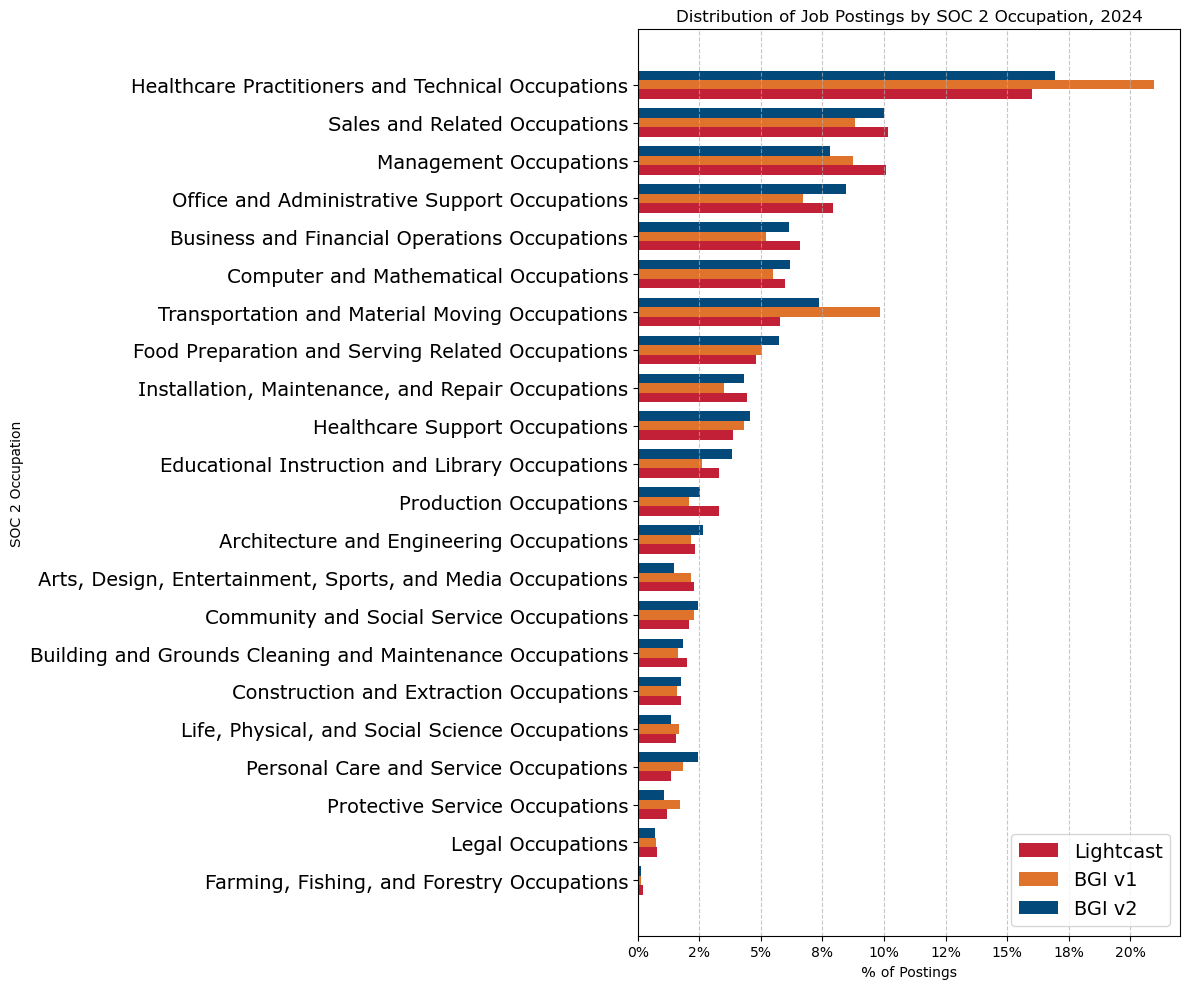

In [17]:
# Chart: SOC 2 distribution comparison (horizontal bar) - 3 sources
import numpy as np

# Filter out military/unclassified and sort by LC percentage
soc2_chart_data = soc2_dist_comparison[
    ~soc2_dist_comparison['SOC_2_NAME'].str.lower().str.contains('military|unclassified', na=False)
].sort_values('LC_PCT', ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))
y = np.arange(len(soc2_chart_data))
height = 0.25  # narrower bars for 3 groups

ax.barh(y - height, soc2_chart_data['LC_PCT'], height, label='Lightcast', color='#C22036')
ax.barh(y, soc2_chart_data['BGI_V1_PCT'], height, label='BGI v1', color='#E0732B')
ax.barh(y + height, soc2_chart_data['BGI_V2_PCT'], height, label='BGI v2', color='#03497A')

ax.set_xlabel('% of Postings', fontname='Verdana')
ax.set_ylabel('SOC 2 Occupation', fontname='Verdana')
ax.set_title('Distribution of Job Postings by SOC 2 Occupation, 2024', fontname='Verdana')
ax.set_yticks(y)
ax.set_yticklabels(soc2_chart_data['SOC_2_NAME'], fontname='Verdana', fontsize=14)
ax.legend(loc='lower right', fontsize = 14)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 3.3 Comparison with OEWS 

In [18]:
# Benchmark: Postings distribution vs OEWS employment by SOC 2

# Load OEWS national employment data (May 2024)
oews_path = r"C:\Users\JuliaNania\OneDrive - Burning Glass Institute\Documents\GitHub\release_comparisons\oews_empl_national_M2024_dl.xlsx"
oews_raw = pd.read_excel(oews_path)

# Filter to major occupation groups only
oews_major = oews_raw[oews_raw['O_GROUP'] == 'major'].copy()

# Convert TOT_EMPL to numeric (BLS may use ** for suppressed values)
oews_major['TOT_EMP'] = pd.to_numeric(oews_major['TOT_EMP'], errors='coerce')
oews_major = oews_major.dropna(subset=['TOT_EMP'])

# Compute employment share
oews_total = oews_major['TOT_EMP'].sum()
oews_major['OEWS_PCT'] = (oews_major['TOT_EMP'] / oews_total) * 100

# Keep relevant columns for merge
oews_for_merge = oews_major[['OCC_TITLE', 'TOT_EMP', 'OEWS_PCT']].rename(
    columns={'OCC_TITLE': 'SOC_2_NAME', 'TOT_EMP': 'OEWS_EMPL'}
)

# Merge with existing postings distribution (case-insensitive)
oews_for_merge['SOC_2_NAME_LOWER'] = oews_for_merge['SOC_2_NAME'].str.lower().str.strip()
soc2_dist_comparison['SOC_2_NAME_LOWER'] = soc2_dist_comparison['SOC_2_NAME'].str.lower().str.strip()

benchmark_comparison = soc2_dist_comparison.merge(
    oews_for_merge, on='SOC_2_NAME_LOWER', how='outer', suffixes=('', '_OEWS')
)
# Use the postings SOC name where available, else OEWS name
benchmark_comparison['SOC_2_NAME'] = benchmark_comparison['SOC_2_NAME'].fillna(benchmark_comparison['SOC_2_NAME_OEWS'])
benchmark_comparison = benchmark_comparison.drop(columns=['SOC_2_NAME_LOWER', 'SOC_2_NAME_OEWS'], errors='ignore')
benchmark_comparison = benchmark_comparison.fillna(0).sort_values('OEWS_PCT', ascending=False)

print(f"OEWS total employment (major groups): {oews_total:,.0f}\n")
display(benchmark_comparison[['SOC_2_NAME', 'LC_PCT', 'BGI_V1_PCT', 'BGI_V2_PCT', 'OEWS_PCT']].style.format({
    'LC_PCT': '{:.1f}%',
    'BGI_V1_PCT': '{:.1f}%',
    'BGI_V2_PCT': '{:.1f}%',
    'OEWS_PCT': '{:.1f}%'
}))

OEWS total employment (major groups): 154,187,380



,SOC_2_NAME,LC_PCT,BGI_V1_PCT,BGI_V2_PCT,OEWS_PCT
18,Office and Administrative Support Occupations,7.9%,6.7%,8.5%,11.8%
23,Transportation and Material Moving Occupations,5.8%,9.8%,7.4%,8.9%
9,Food Preparation and Serving Related Occupations,4.8%,5.0%,5.7%,8.8%
22,Sales and Related Occupations,10.1%,8.8%,10.0%,8.7%
15,Management Occupations,10.1%,8.8%,7.8%,7.1%
3,Business and Financial Operations Occupations,6.6%,5.2%,6.1%,6.7%
10,Healthcare Practitioners and Technical Occupations,16.0%,21.0%,17.0%,6.2%
7,Educational Instruction and Library Occupations,3.3%,2.6%,3.8%,5.8%
20,Production Occupations,3.3%,2.1%,2.5%,5.7%
11,Healthcare Support Occupations,3.9%,4.3%,4.6%,4.8%


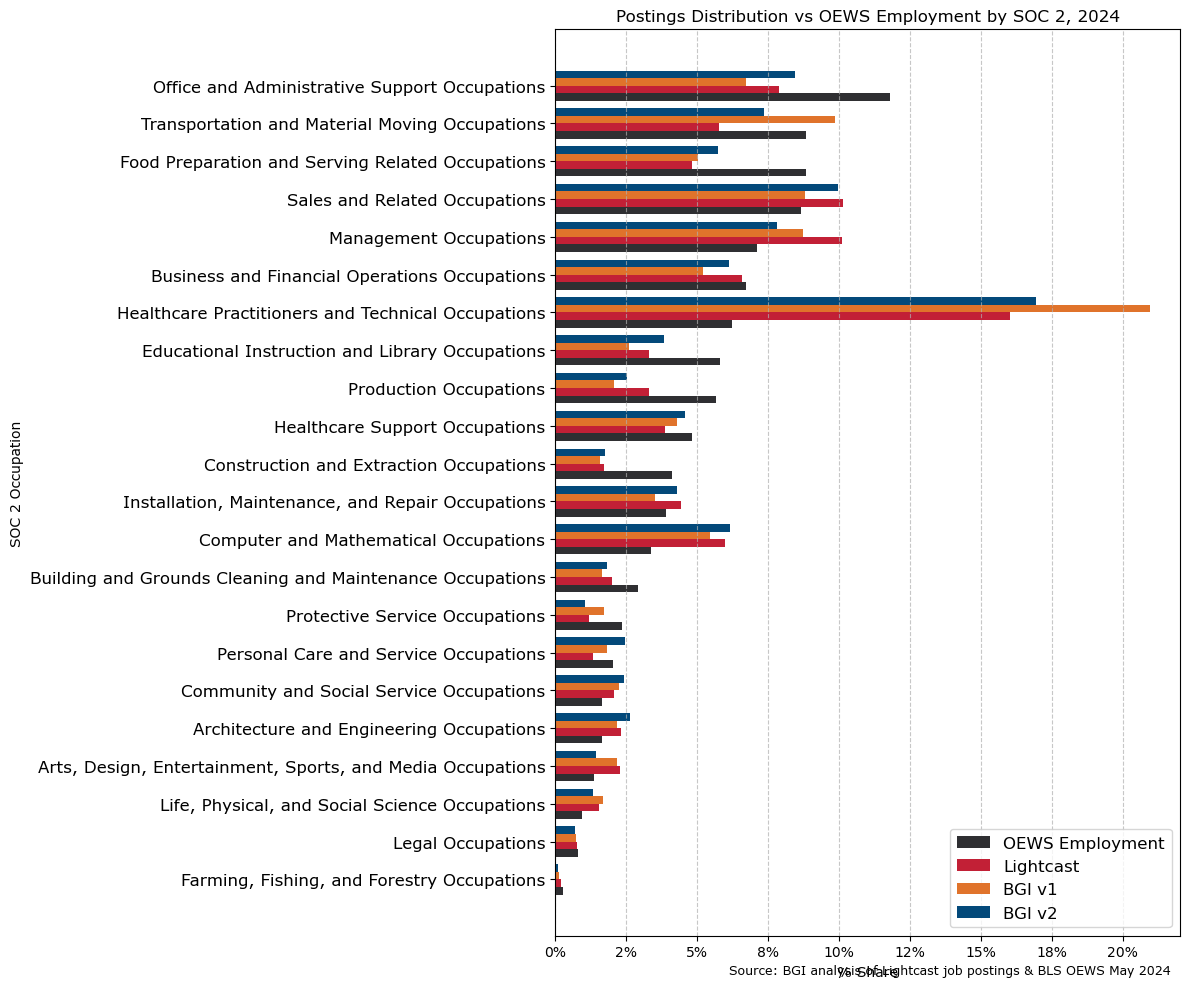

In [ ]:
# Chart: Postings vs OEWS employment distribution by SOC 2 (horizontal bar)
import numpy as np

# Filter out military/unclassified and sort by OEWS employment share
bench_chart = benchmark_comparison[
    ~benchmark_comparison['SOC_2_NAME'].str.lower().str.contains('military|unclassified', na=False)
].sort_values('OEWS_PCT', ascending=True)

fig, ax = plt.subplots(figsize=(12, 10))
y = np.arange(len(bench_chart))
height = 0.2  # narrower bars for 4 groups

# Four grouped bars per occupation
ax.barh(y - 1.5*height, bench_chart['OEWS_PCT'], height, label='OEWS Employment', color='#2F2F32')
ax.barh(y - 0.5*height, bench_chart['LC_PCT'], height, label='Lightcast', color='#C22036')
ax.barh(y + 0.5*height, bench_chart['BGI_V1_PCT'], height, label='BGI v1', color='#E0732B')
ax.barh(y + 1.5*height, bench_chart['BGI_V2_PCT'], height, label='BGI v2', color='#03497A')

ax.set_xlabel('% Share', fontname='Verdana')
ax.set_ylabel('SOC 2 Occupation', fontname='Verdana')
ax.set_title('Postings Distribution vs OEWS Employment by SOC 2, 2024', fontname='Verdana')
ax.set_yticks(y)
ax.set_yticklabels(bench_chart['SOC_2_NAME'], fontname='Verdana', fontsize=12)
ax.legend(loc='lower right', fontsize=12)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

fig.text(0.98, 0.02, 'Source: BGI analysis of Lightcast job postings & BLS OEWS May 2024',
         ha='right', fontsize=9, fontname='Verdana')
plt.tight_layout()
plt.show()

### 3.4 Comparison with OEWS at Detailed SOC Level
Comparing posting distribution by 6-digit SOC (truncated from ONET) against OEWS national employment at the detailed occupation level.

In [10]:
# Postings distribution by 6-digit SOC (truncated ONET) for each source

# Lightcast: join ONET name to lookup table to get code, then truncate
lc_soc6_query = """
SELECT 
    LEFT(lu.BGI_ONET, 7) AS SOC_CODE,
    COUNT(*) AS POSTING_COUNT
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS lc
INNER JOIN temporary_data.jnania.onet_soc_lookup lu
    ON UPPER(TRIM(lc.ONET_2019_NAME)) = UPPER(TRIM(lu.BGI_ONET_NAME))
WHERE lc.ONET_2019_NAME IS NOT NULL AND YEAR(lc.POSTED) = 2024
GROUP BY 1
ORDER BY 2 DESC
"""
lc_soc6 = run_query(lc_soc6_query)
lc_soc6_total = lc_soc6['POSTING_COUNT'].sum()
lc_soc6['PCT'] = (lc_soc6['POSTING_COUNT'] / lc_soc6_total) * 100

# BGI v1: truncate ONET_CODE to 6-digit SOC
v1_soc6_query = """
SELECT 
    LEFT(v1.ONET_CODE, 7) AS SOC_CODE,
    COUNT(*) AS POSTING_COUNT
FROM REVELIO_CLEAN.V1.BGI_POSTINGS v1
WHERE v1.ONET_CODE IS NOT NULL
  AND v1.BGI_COUNTRY = 'United States'
  AND YEAR(v1.POST_DATE) = 2024
GROUP BY 1
ORDER BY 2 DESC
"""
v1_soc6 = run_query(v1_soc6_query)
v1_soc6_total = v1_soc6['POSTING_COUNT'].sum()
v1_soc6['PCT'] = (v1_soc6['POSTING_COUNT'] / v1_soc6_total) * 100

# BGI v2: truncate TOP1_CODE to 6-digit SOC
v2_soc6_query = """
SELECT 
    LEFT(occ.TOP1_CODE, 7) AS SOC_CODE,
    COUNT(*) AS POSTING_COUNT
FROM PROJECT_DATA.POSTINGS_OCCUPATION_CLASSIFIER.CLEAN_POSTINGS_V2_NEW_RUN_ALL occ
INNER JOIN revelio_clean.experimental_readonly.v2_postings_filtered p ON p.desc_id = occ.desc_id
WHERE occ.TOP1_CODE IS NOT NULL AND YEAR(p.post_date) = 2024
GROUP BY 1
ORDER BY 2 DESC
"""
v2_soc6 = run_query(v2_soc6_query)
v2_soc6_total = v2_soc6['POSTING_COUNT'].sum()
v2_soc6['PCT'] = (v2_soc6['POSTING_COUNT'] / v2_soc6_total) * 100

# Merge all three on SOC_CODE
soc6_comparison = lc_soc6[['SOC_CODE', 'POSTING_COUNT', 'PCT']].rename(
    columns={'POSTING_COUNT': 'LC_COUNT', 'PCT': 'LC_PCT'}
).merge(
    v1_soc6[['SOC_CODE', 'POSTING_COUNT', 'PCT']].rename(
        columns={'POSTING_COUNT': 'V1_COUNT', 'PCT': 'V1_PCT'}
    ), on='SOC_CODE', how='outer'
).merge(
    v2_soc6[['SOC_CODE', 'POSTING_COUNT', 'PCT']].rename(
        columns={'POSTING_COUNT': 'V2_COUNT', 'PCT': 'V2_PCT'}
    ), on='SOC_CODE', how='outer'
).fillna(0)

print(f"Lightcast postings with 6-digit SOC: {lc_soc6_total:,.0f}")
print(f"BGI v1 postings with 6-digit SOC: {v1_soc6_total:,.0f}")
print(f"BGI v2 postings with 6-digit SOC: {v2_soc6_total:,.0f}")

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_21156\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_21156\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_21156\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



Lightcast postings with 6-digit SOC: 36,821,414
BGI v1 postings with 6-digit SOC: 100,650,044
BGI v2 postings with 6-digit SOC: 113,575,955


In [12]:
# Load OEWS detailed employment and merge with postings

# Filter OEWS to detailed occupation level
oews_detailed = oews_raw[oews_raw['O_GROUP'] == 'detailed'].copy()
oews_detailed['TOT_EMP'] = pd.to_numeric(oews_detailed['TOT_EMP'], errors='coerce')
oews_detailed = oews_detailed.dropna(subset=['TOT_EMP'])

# Compute employment share
oews_det_total = oews_detailed['TOT_EMP'].sum()
oews_detailed['OEWS_PCT'] = (oews_detailed['TOT_EMP'] / oews_det_total) * 100

# Keep columns for merge
oews_det_merge = oews_detailed[['OCC_CODE', 'OCC_TITLE', 'TOT_EMP', 'OEWS_PCT']].rename(
    columns={'OCC_CODE': 'SOC_CODE', 'TOT_EMP': 'OEWS_EMPL'}
)

# Merge OEWS with postings comparison
soc6_benchmark = soc6_comparison.merge(oews_det_merge, on='SOC_CODE', how='outer').fillna(0)
soc6_benchmark = soc6_benchmark.sort_values('OEWS_PCT', ascending=False)

print(f"OEWS total employment (detailed): {oews_det_total:,.0f}")
print(f"Matched SOC codes: {(soc6_benchmark['OEWS_PCT'] > 0).sum()} OEWS, "
      f"{(soc6_benchmark['V2_PCT'] > 0).sum()} BGI v2\n")

# Show top 20 by OEWS employment share
display(soc6_benchmark.head(20).style.format({
    'LC_COUNT': '{:,.0f}', 'V1_COUNT': '{:,.0f}', 'V2_COUNT': '{:,.0f}',
    'OEWS_EMPL': '{:,.0f}',
    'LC_PCT': '{:.2f}%', 'V1_PCT': '{:.2f}%', 'V2_PCT': '{:.2f}%', 'OEWS_PCT': '{:.2f}%'
}))

NameError: name 'oews_raw' is not defined

In [ ]:
# Scatter plot: OEWS employment % vs Postings % by detailed SOC
import plotly.graph_objects as go
import numpy as np

# Filter to occupations present in OEWS
scatter_df = soc6_benchmark[(soc6_benchmark['OEWS_PCT'] > 0)].copy()
# Use OCC_TITLE for hover; fill blanks with SOC code
scatter_df['LABEL'] = scatter_df['OCC_TITLE'].replace(0, '').replace('', np.nan)
scatter_df['LABEL'] = scatter_df['LABEL'].fillna(scatter_df['SOC_CODE'])

fig = go.Figure()

# BGI v2 trace (primary)
fig.add_trace(go.Scatter(
    x=scatter_df['OEWS_PCT'], y=scatter_df['V2_PCT'],
    mode='markers', name='BGI v2',
    marker=dict(color='#03497A', size=6, opacity=0.7),
    text=scatter_df['LABEL'],
    hovertemplate='<b>%{text}</b><br>OEWS: %{x:.2f}%<br>BGI v2: %{y:.2f}%<extra></extra>'
))

# BGI v1 trace (toggleable)
fig.add_trace(go.Scatter(
    x=scatter_df['OEWS_PCT'], y=scatter_df['V1_PCT'],
    mode='markers', name='BGI v1', visible='legendonly',
    marker=dict(color='#E0732B', size=6, opacity=0.7),
    text=scatter_df['LABEL'],
    hovertemplate='<b>%{text}</b><br>OEWS: %{x:.2f}%<br>BGI v1: %{y:.2f}%<extra></extra>'
))

# Lightcast trace (toggleable)
fig.add_trace(go.Scatter(
    x=scatter_df['OEWS_PCT'], y=scatter_df['LC_PCT'],
    mode='markers', name='Lightcast', visible='legendonly',
    marker=dict(color='#C22036', size=6, opacity=0.7),
    text=scatter_df['LABEL'],
    hovertemplate='<b>%{text}</b><br>OEWS: %{x:.2f}%<br>Lightcast: %{y:.2f}%<extra></extra>'
))

# 45-degree reference line
max_val = max(scatter_df['OEWS_PCT'].max(), scatter_df['V2_PCT'].max()) * 1.1
fig.add_trace(go.Scatter(
    x=[0, max_val], y=[0, max_val],
    mode='lines', name='y = x',
    line=dict(color='grey', dash='dash', width=1),
    showlegend=False
))

fig.update_layout(
    title='Postings Share vs OEWS Employment Share by Detailed SOC, 2024',
    font=dict(family='Verdana'),
    height=600, width=800,
    xaxis=dict(type='log', title='OEWS Employment Share (%, log scale)'),
    yaxis=dict(type='log', title='Postings Share (%, log scale)'),
)

fig.show()

# R-squared: BGI v2 vs OEWS (log-log)
valid = scatter_df[(scatter_df['V2_PCT'] > 0) & (scatter_df['OEWS_PCT'] > 0)]
r_sq = np.corrcoef(np.log10(valid['OEWS_PCT']), np.log10(valid['V2_PCT']))[0, 1] ** 2
print(f"R-squared (log-log, BGI v2 vs OEWS): {r_sq:.3f}")

In [ ]:
# Top 25 occupations with largest OEWS-vs-BGI v2 percentage-point difference

soc6_benchmark['DIFF_PP'] = soc6_benchmark['V2_PCT'] - soc6_benchmark['OEWS_PCT']
soc6_benchmark['ABS_DIFF'] = soc6_benchmark['DIFF_PP'].abs()

top_diffs = soc6_benchmark.nlargest(25, 'ABS_DIFF')[[
    'SOC_CODE', 'OCC_TITLE', 'OEWS_PCT', 'V2_PCT', 'DIFF_PP'
]].copy()

print('=== Top 25 Occupations: Largest Difference (BGI v2 minus OEWS) ===\n')
display(top_diffs.style.format({
    'OEWS_PCT': '{:.2f}%',
    'V2_PCT': '{:.2f}%',
    'DIFF_PP': '{:+.2f} pp'
}))

## 3.5 ONET Classification Changes: BGI v1 vs v2
Analyzing which ONET codes changed between BGI v1 and v2 classifications for 2024 postings

In [20]:
# Most common ONET changes between BGI v1 and v2 (2024)
onet_changes_query = """
SELECT 
    v1.ONET_CODE AS V1_ONET,
    lu_v1.BGI_ONET_NAME AS V1_ONET_NAME,
    occ.TOP1_CODE AS V2_ONET,
    lu_v2.BGI_ONET_NAME AS V2_ONET_NAME,
    COUNT(*) AS POSTING_COUNT
FROM REVELIO_CLEAN.V1.BGI_POSTINGS v1
INNER JOIN PROJECT_DATA.POSTINGS_OCCUPATION_CLASSIFIER.CLEAN_POSTINGS_V2_NEW_RUN_ALL occ 
    ON occ.DESC_ID = v1.DESC_ID
LEFT JOIN temporary_data.jnania.onet_soc_lookup lu_v1 ON lu_v1.BGI_ONET = v1.ONET_CODE
LEFT JOIN temporary_data.jnania.onet_soc_lookup lu_v2 ON lu_v2.BGI_ONET = occ.TOP1_CODE
WHERE v1.BGI_COUNTRY = 'United States'
  AND YEAR(v1.POST_DATE) = 2024
  AND v1.ONET_CODE IS NOT NULL
  AND occ.TOP1_CODE IS NOT NULL
  AND v1.ONET_CODE != occ.TOP1_CODE  -- only show changes
GROUP BY 1, 2, 3, 4
ORDER BY 5 DESC
LIMIT 30
"""
onet_changes = run_query(onet_changes_query)

print("=== Most Common ONET Classification Changes: BGI v1 → v2 (2024) ===\n")
display(onet_changes.style.format({'POSTING_COUNT': '{:,.0f}'}))

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_9148\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


=== Most Common ONET Classification Changes: BGI v1 → v2 (2024) ===



,V1_ONET,V1_ONET_NAME,V2_ONET,V2_ONET_NAME,POSTING_COUNT
0,29-2061.00,Licensed Practical and Licensed Vocational Nurses,29-1141.00,Registered Nurses,"3,332,259"
1,53-3033.00,Light Truck Drivers,53-3032.00,Heavy and Tractor-Trailer Truck Drivers,"1,617,452"
2,11-9111.00,Medical and Health Services Managers,29-1141.00,Registered Nurses,"704,379"
3,41-1011.00,First-Line Supervisors of Retail Sales Workers,41-2031.00,Retail Salespersons,"668,254"
4,47-5041.00,Continuous Mining Machine Operators,53-3032.00,Heavy and Tractor-Trailer Truck Drivers,"626,012"
5,35-3041.00,"Food Servers, Nonrestaurant",35-3023.00,Fast Food and Counter Workers,"549,764"
6,31-1121.00,Home Health Aides,31-1122.00,Personal Care Aides,"544,092"
7,29-2061.00,Licensed Practical and Licensed Vocational Nurses,29-1141.01,Acute Care Nurses,"434,997"
8,31-1121.00,Home Health Aides,31-1131.00,Nursing Assistants,"416,569"
9,31-9097.00,Phlebotomists,31-9092.00,Medical Assistants,"405,517"


In [21]:
# Summary: How many postings changed ONET classification?
onet_change_summary_query = """
SELECT 
    SUM(CASE WHEN v1.ONET_CODE = occ.TOP1_CODE THEN 1 ELSE 0 END) AS SAME_ONET,
    SUM(CASE WHEN v1.ONET_CODE != occ.TOP1_CODE THEN 1 ELSE 0 END) AS DIFFERENT_ONET,
    COUNT(*) AS TOTAL_MATCHED
FROM REVELIO_CLEAN.V1.BGI_POSTINGS v1
INNER JOIN PROJECT_DATA.POSTINGS_OCCUPATION_CLASSIFIER.CLEAN_POSTINGS_V2_NEW_RUN_ALL occ 
    ON occ.DESC_ID = v1.DESC_ID
WHERE v1.BGI_COUNTRY = 'United States'
  AND YEAR(v1.POST_DATE) = 2024
  AND v1.ONET_CODE IS NOT NULL
  AND occ.TOP1_CODE IS NOT NULL
"""
onet_summary = run_query(onet_change_summary_query)
onet_summary['PCT_SAME'] = (onet_summary['SAME_ONET'] / onet_summary['TOTAL_MATCHED']) * 100
onet_summary['PCT_CHANGED'] = (onet_summary['DIFFERENT_ONET'] / onet_summary['TOTAL_MATCHED']) * 100

print("=== ONET Classification Agreement: BGI v1 vs v2 (2024) ===\n")
display(onet_summary.style.format({
    'SAME_ONET': '{:,.0f}',
    'DIFFERENT_ONET': '{:,.0f}',
    'TOTAL_MATCHED': '{:,.0f}',
    'PCT_SAME': '{:.1f}%',
    'PCT_CHANGED': '{:.1f}%'
}))

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_9148\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


=== ONET Classification Agreement: BGI v1 vs v2 (2024) ===



,SAME_ONET,DIFFERENT_ONET,TOTAL_MATCHED,PCT_SAME,PCT_CHANGED
0,"13,388,297","85,067,282","98,455,579",13.6%,86.4%


# 4. Industry Analysis
Comparing job posting distribution by NAICS 2 industry between Lightcast, BGI v1, and BGI v2

### 4.1 Distribution by NAICS 2 Industry
Comparing posting distribution across broad industry categories

In [29]:
# Distribution by NAICS 2 industry (Lightcast, BGI v1, BGI v2)

# Lightcast: distribution by NAICS2_NAME
lc_naics2_query = """
SELECT 
    NAICS2_NAME,
    COUNT(*) AS POSTING_COUNT
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE NAICS2_NAME IS NOT NULL AND YEAR(POSTED) = 2024
GROUP BY 1
ORDER BY 2 DESC
"""
lc_naics2 = run_query(lc_naics2_query)
lc_total_naics = lc_naics2['POSTING_COUNT'].sum()
lc_naics2['PCT'] = (lc_naics2['POSTING_COUNT'] / lc_total_naics) * 100

# BGI v1: distribution by BGI_NAICS2_NAME
bgi_v1_naics2_query = """
SELECT 
    BGI_NAICS2_NAME AS NAICS2_NAME,
    COUNT(*) AS POSTING_COUNT
FROM REVELIO_CLEAN.V1.BGI_POSTINGS
WHERE BGI_NAICS2_NAME IS NOT NULL 
  AND BGI_COUNTRY = 'United States'
  AND YEAR(POST_DATE) = 2024
GROUP BY 1
ORDER BY 2 DESC
"""
bgi_v1_naics2 = run_query(bgi_v1_naics2_query)
bgi_v1_total_naics = bgi_v1_naics2['POSTING_COUNT'].sum()
bgi_v1_naics2['PCT'] = (bgi_v1_naics2['POSTING_COUNT'] / bgi_v1_total_naics) * 100

# BGI v2: join with employer data and NAICS hierarchy
bgi_v2_naics2_query = """
SELECT 
    nh.naics_2022_2_name AS NAICS2_NAME,
    COUNT(*) AS POSTING_COUNT
FROM REVELIO_CLEAN.EXPERIMENTAL_READONLY.V2_POSTINGS_FILTERED posts
LEFT JOIN TEMPORARY_DATA.MBONE.MISSING_RCIDS_V2 miss ON posts.JOB_ID = miss.JOB_ID
LEFT JOIN TEMPORARY_DATA.MBONE.MASTER_EMPLOYERS_V2 emps ON COALESCE(miss.IMPUTED_RCID, posts.RCID) = emps.REV_BASE_ID
INNER JOIN TEMPORARY_DATA.SSWEE.NAICS_FULL_HIERARCHY nh ON nh.naics_2022_6 = emps.BGI_NAICS_TOP1
WHERE emps.BGI_NAICS_TOP1 IS NOT NULL
  AND posts.country = 'United States'
  AND YEAR(posts.POST_DATE) = 2024
GROUP BY 1
ORDER BY 2 DESC
"""
bgi_v2_naics2 = run_query(bgi_v2_naics2_query)
bgi_v2_total_naics = bgi_v2_naics2['POSTING_COUNT'].sum()
bgi_v2_naics2['PCT'] = (bgi_v2_naics2['POSTING_COUNT'] / bgi_v2_total_naics) * 100

# JOLTS: pull vacancy counts for specific industry codes
jolts_query = """
SELECT 
    j."industry_code" AS IND_CODE,
    j."industry_text" AS SECTOR,
    SUM(j."job_openings") AS VACANCY_COUNT
FROM OUTSIDE_DATA.JOLTS.ALL_DATA j
WHERE j."state_text" = 'Total US'
  AND j."industry_code" IN (
      '110099','230000','300000','420000','440000','480099',
      '510000','520000','530000','540099',
      '610000','620000','710000','720000','810000','900000'
  )
  AND j."year" = '2024'
GROUP BY 1, 2
ORDER BY 3 DESC
"""
jolts_raw = run_query(jolts_query)
jolts_raw['SECTOR'] = jolts_raw['SECTOR'].str.strip()

# Map JOLTS industry_code → common SECTOR label
JOLTS_CODE_TO_SECTOR = {
    '110099': 'Mining, Quarrying, and Oil and Gas Extraction',
    '230000': 'Construction',
    '300000': 'Manufacturing',
    '420000': 'Wholesale Trade',
    '440000': 'Retail Trade',
    '480099': 'Transportation, Warehousing, and Utilities',
    '510000': 'Information',
    '520000': 'Finance and Insurance',
    '530000': 'Real Estate and Rental and Leasing',
    '540099': 'Professional and Business Services',
    '610000': 'Educational Services',
    '620000': 'Health Care and Social Assistance',
    '710000': 'Arts, Entertainment, and Recreation',
    '720000': 'Accommodation and Food Services',
    '810000': 'Other Services (except Public Administration)',
    '900000': 'Public Administration',
}

# Map by code (avoids industry_text string-matching issues)
jolts_raw['SECTOR'] = jolts_raw['IND_CODE'].map(JOLTS_CODE_TO_SECTOR)
jolts_sector = jolts_raw.dropna(subset=['SECTOR']).groupby('SECTOR')['VACANCY_COUNT'].sum().reset_index()
jolts_total = jolts_sector['VACANCY_COUNT'].sum()
jolts_sector['JOLTS_PCT'] = (jolts_sector['VACANCY_COUNT'] / jolts_total) * 100

# Map postings NAICS2_NAME → common SECTOR label (combine where JOLTS forces it)
NAICS2_TO_SECTOR = {
    'Agriculture, Forestry, Fishing and Hunting': None,                                          # not in JOLTS
    'Mining, Quarrying, and Oil and Gas Extraction': 'Mining, Quarrying, and Oil and Gas Extraction',
    'Utilities': 'Transportation, Warehousing, and Utilities',                                   # combined
    'Construction': 'Construction',
    'Manufacturing': 'Manufacturing',
    'Wholesale Trade': 'Wholesale Trade',
    'Retail Trade': 'Retail Trade',
    'Transportation and Warehousing': 'Transportation, Warehousing, and Utilities',              # combined
    'Information': 'Information',
    'Finance and Insurance': 'Finance and Insurance',
    'Real Estate and Rental and Leasing': 'Real Estate and Rental and Leasing',
    'Professional, Scientific, and Technical Services': 'Professional and Business Services',     # combined
    'Management of Companies and Enterprises': 'Professional and Business Services',             # combined
    'Administrative and Support and Waste Management and Remediation Services': 'Professional and Business Services',  # combined
    'Educational Services': 'Educational Services',
    'Health Care and Social Assistance': 'Health Care and Social Assistance',
    'Arts, Entertainment, and Recreation': 'Arts, Entertainment, and Recreation',
    'Accommodation and Food Services': 'Accommodation and Food Services',
    'Other Services (except Public Administration)': 'Other Services (except Public Administration)',
    'Public Administration': 'Public Administration',
}

# Aggregate postings to sector level
def agg_to_sector(df, count_col):
    tmp = df.copy()
    tmp['SECTOR'] = tmp['NAICS2_NAME'].map(NAICS2_TO_SECTOR)
    return tmp.dropna(subset=['SECTOR']).groupby('SECTOR')[count_col].sum().reset_index()

lc_sector = agg_to_sector(lc_naics2, 'POSTING_COUNT').rename(columns={'POSTING_COUNT': 'LC_COUNT'})
lc_sector['LC_PCT'] = (lc_sector['LC_COUNT'] / lc_sector['LC_COUNT'].sum()) * 100

bgi_v1_sector = agg_to_sector(bgi_v1_naics2, 'POSTING_COUNT').rename(columns={'POSTING_COUNT': 'BGI_V1_COUNT'})
bgi_v1_sector['BGI_V1_PCT'] = (bgi_v1_sector['BGI_V1_COUNT'] / bgi_v1_sector['BGI_V1_COUNT'].sum()) * 100

bgi_v2_sector = agg_to_sector(bgi_v2_naics2, 'POSTING_COUNT').rename(columns={'POSTING_COUNT': 'BGI_V2_COUNT'})
bgi_v2_sector['BGI_V2_PCT'] = (bgi_v2_sector['BGI_V2_COUNT'] / bgi_v2_sector['BGI_V2_COUNT'].sum()) * 100

# Merge all four sources on common SECTOR label
sector_comparison = lc_sector.merge(bgi_v1_sector, on='SECTOR', how='outer').merge(
    bgi_v2_sector, on='SECTOR', how='outer'
).merge(
    jolts_sector[['SECTOR', 'VACANCY_COUNT', 'JOLTS_PCT']].rename(columns={'VACANCY_COUNT': 'JOLTS_COUNT'}),
    on='SECTOR', how='outer'
).fillna(0).sort_values('LC_PCT', ascending=False)

print(f"Lightcast total postings: {lc_total_naics:,.0f}")
print(f"BGI v1 total postings: {bgi_v1_total_naics:,.0f}")
print(f"BGI v2 total postings: {bgi_v2_total_naics:,.0f}")
print(f"JOLTS total vacancies (2024): {jolts_total:,.0f}\n")
display(sector_comparison.style.format({
    'LC_COUNT': '{:,.0f}',
    'BGI_V1_COUNT': '{:,.0f}',
    'BGI_V2_COUNT': '{:,.0f}',
    'JOLTS_COUNT': '{:,.0f}',
    'LC_PCT': '{:.1f}%',
    'BGI_V1_PCT': '{:.1f}%',
    'BGI_V2_PCT': '{:.1f}%',
    'JOLTS_PCT': '{:.1f}%'
}))

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_8128\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_8128\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_8128\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)
C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_8128\1144319068.py:3: UserWarning

Lightcast total postings: 36,821,414
BGI v1 total postings: 89,305,262
BGI v2 total postings: 92,026,177
JOLTS total vacancies (2024): 194,487



,SECTOR,LC_COUNT,LC_PCT,BGI_V1_COUNT,BGI_V1_PCT,BGI_V2_COUNT,BGI_V2_PCT,JOLTS_COUNT,JOLTS_PCT
10,Professional and Business Services,"8,124,827",26.0%,"34,547,670",38.7%,"30,311,996",33.0%,"33,973",17.5%
5,Health Care and Social Assistance,"5,732,182",18.3%,"13,959,833",15.6%,"11,373,718",12.4%,"39,358",20.2%
13,Retail Trade,"3,422,409",10.9%,"6,991,543",7.8%,"7,131,749",7.8%,"12,976",6.7%
7,Manufacturing,"2,488,325",8.0%,"4,545,946",5.1%,"7,295,972",7.9%,"12,316",6.3%
0,Accommodation and Food Services,"1,857,052",5.9%,"5,266,923",5.9%,"5,494,226",6.0%,"22,224",11.4%
3,Educational Services,"1,840,582",5.9%,"4,868,691",5.5%,"5,737,836",6.2%,"4,266",2.2%
4,Finance and Insurance,"1,453,015",4.6%,"3,281,328",3.7%,"5,329,240",5.8%,"8,178",4.2%
15,Wholesale Trade,"1,104,387",3.5%,"2,000,138",2.2%,"1,568,573",1.7%,"4,235",2.2%
14,"Transportation, Warehousing, and Utilities","940,991",3.0%,"3,320,144",3.7%,"3,442,296",3.7%,"8,119",4.2%
9,Other Services (except Public Administration),"856,067",2.7%,"2,233,726",2.5%,"1,721,903",1.9%,"7,393",3.8%


In [ ]:
jolts_raw

In [31]:
# Sectors with largest differences between Lightcast and BGI v2
diff_lc = sector_comparison[['SECTOR', 'LC_PCT', 'BGI_V2_PCT']].copy()
diff_lc['DIFF'] = diff_lc['LC_PCT'] - diff_lc['BGI_V2_PCT']  # positive = LC higher
diff_lc['ABS_DIFF'] = diff_lc['DIFF'].abs()
diff_lc = diff_lc.sort_values('ABS_DIFF', ascending=False)

print("=== Sectors with Largest Differences: Lightcast vs BGI v2 ===\n")
display(diff_lc.style.format({
    'LC_PCT': '{:.1f}%',
    'BGI_V2_PCT': '{:.1f}%',
    'DIFF': '{:+.1f}pp',
    'ABS_DIFF': '{:.1f}pp'
}))

# Sectors with largest differences between BGI v1 and BGI v2
diff_bgi = sector_comparison[['SECTOR', 'BGI_V1_PCT', 'BGI_V2_PCT']].copy()
diff_bgi['DIFF'] = diff_bgi['BGI_V2_PCT'] - diff_bgi['BGI_V1_PCT']  # positive = v2 higher
diff_bgi['ABS_DIFF'] = diff_bgi['DIFF'].abs()
diff_bgi = diff_bgi.sort_values('ABS_DIFF', ascending=False)

print("\n=== Sectors with Largest Differences: BGI v1 vs BGI v2 ===\n")
display(diff_bgi.style.format({
    'BGI_V1_PCT': '{:.1f}%',
    'BGI_V2_PCT': '{:.1f}%',
    'DIFF': '{:+.1f}pp',
    'ABS_DIFF': '{:.1f}pp'
}))

=== Sectors with Largest Differences: Lightcast vs BGI v2 ===



,SECTOR,LC_PCT,BGI_V2_PCT,DIFF,ABS_DIFF
10,Professional and Business Services,26.0%,33.0%,-7.0pp,7.0pp
5,Health Care and Social Assistance,18.3%,12.4%,+6.0pp,6.0pp
13,Retail Trade,10.9%,7.8%,+3.2pp,3.2pp
6,Information,2.4%,4.3%,-1.8pp,1.8pp
15,Wholesale Trade,3.5%,1.7%,+1.8pp,1.8pp
11,Public Administration,2.5%,3.8%,-1.3pp,1.3pp
4,Finance and Insurance,4.6%,5.8%,-1.2pp,1.2pp
2,Construction,2.7%,1.7%,+1.0pp,1.0pp
9,Other Services (except Public Administration),2.7%,1.9%,+0.9pp,0.9pp
1,"Arts, Entertainment, and Recreation",1.0%,1.9%,-0.9pp,0.9pp



=== Sectors with Largest Differences: BGI v1 vs BGI v2 ===



,SECTOR,BGI_V1_PCT,BGI_V2_PCT,DIFF,ABS_DIFF
10,Professional and Business Services,38.7%,33.0%,-5.7pp,5.7pp
5,Health Care and Social Assistance,15.6%,12.4%,-3.3pp,3.3pp
7,Manufacturing,5.1%,7.9%,+2.8pp,2.8pp
6,Information,1.9%,4.3%,+2.4pp,2.4pp
4,Finance and Insurance,3.7%,5.8%,+2.1pp,2.1pp
1,"Arts, Entertainment, and Recreation",0.9%,1.9%,+0.9pp,0.9pp
11,Public Administration,2.8%,3.8%,+0.9pp,0.9pp
3,Educational Services,5.5%,6.2%,+0.8pp,0.8pp
9,Other Services (except Public Administration),2.5%,1.9%,-0.6pp,0.6pp
15,Wholesale Trade,2.2%,1.7%,-0.5pp,0.5pp


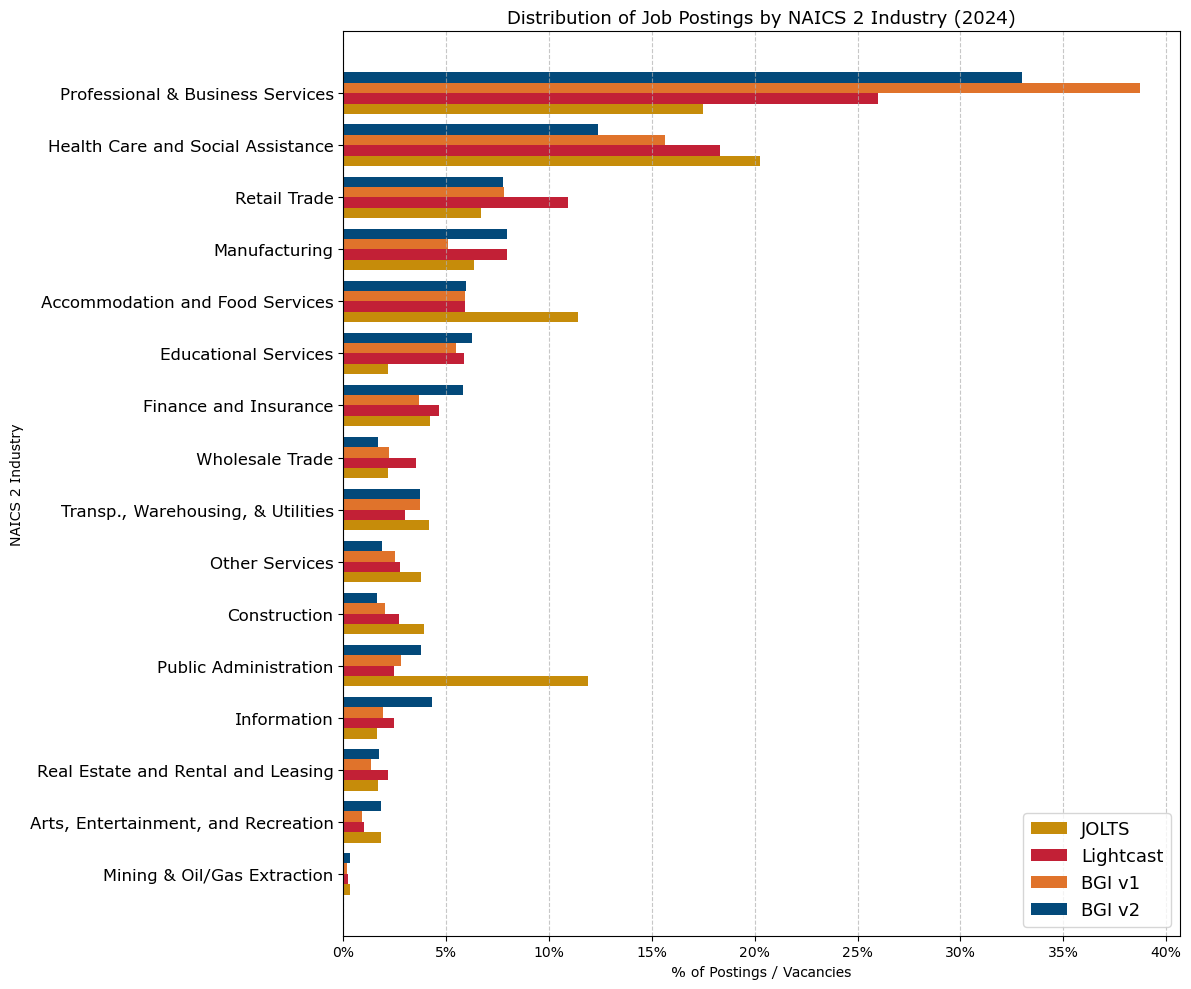

In [ ]:
# Chart: industry distribution comparison (horizontal bar) - 4 sources at NAICS 2 level
import numpy as np

# Shorten long labels for readability
label_map = {
    'Administrative and Support and Waste Management and Remediation Services': 'Admin, Support, & Waste Mgmt',
    'Mining, Quarrying, and Oil and Gas Extraction': 'Mining & Oil/Gas Extraction',
    'Other Services (except Public Administration)': 'Other Services',
    'Transportation, Warehousing, and Utilities': 'Transp., Warehousing, & Utilities',
    'Professional and Business Services': 'Professional & Business Services',
}
chart_data = sector_comparison.sort_values('LC_PCT', ascending=True).copy()
chart_data['LABEL'] = chart_data['SECTOR'].map(lambda x: label_map.get(x, x))

fig, ax = plt.subplots(figsize=(12, 10))
y = np.arange(len(chart_data))
height = 0.2

ax.barh(y - 1.5*height, chart_data['JOLTS_PCT'], height, label='JOLTS', color='#C68C0A')
ax.barh(y - 0.5*height, chart_data['LC_PCT'], height, label='Lightcast', color='#C22036')
ax.barh(y + 0.5*height, chart_data['BGI_V1_PCT'], height, label='BGI v1', color='#E0732B')
ax.barh(y + 1.5*height, chart_data['BGI_V2_PCT'], height, label='BGI v2', color='#03497A')

ax.set_xlabel('% of Postings / Vacancies', fontname='Verdana')
ax.set_ylabel('NAICS 2 Industry', fontname='Verdana')
ax.set_title('Distribution of Job Postings by NAICS 2 Industry (2024)', fontname='Verdana', fontsize=13)
ax.set_yticks(y)
ax.set_yticklabels(chart_data['LABEL'], fontname='Verdana', fontsize=12)
ax.legend(loc='lower right', fontsize=13)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
ax.xaxis.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### 4.2 Industry Coverage at NAICS 2 Level
Share of postings with a NAICS 2 industry assignment by source (2024, US only)

In [51]:
# Industry coverage: share of 2024 US postings with NAICS2 assigned

# Lightcast
lc_ind_cov_query = """
SELECT 
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN NAICS2_NAME IS NOT NULL THEN 1 ELSE 0 END) AS WITH_NAICS2
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE YEAR(POSTED) = 2024
"""
lc_ind_cov = run_query(lc_ind_cov_query)
lc_ind_cov['SOURCE'] = 'Lightcast'

# BGI v1
bgi_v1_ind_cov_query = """
SELECT 
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN BGI_NAICS2_NAME IS NOT NULL THEN 1 ELSE 0 END) AS WITH_NAICS2
FROM REVELIO_CLEAN.V1.BGI_POSTINGS
WHERE BGI_COUNTRY = 'United States'
  AND YEAR(POST_DATE) = 2024
"""
bgi_v1_ind_cov = run_query(bgi_v1_ind_cov_query)
bgi_v1_ind_cov['SOURCE'] = 'BGI v1'

# BGI v2: NAICS comes from employer table join
bgi_v2_ind_cov_query = """
SELECT 
    COUNT(*) AS TOTAL_POSTINGS,
    SUM(CASE WHEN POSTS.BGI_NAICS2_NAME IS NOT NULL THEN 1 ELSE 0 END) AS WITH_NAICS2
FROM REVELIO_CLEAN.BGI_2026_02.BGI_POSTINGS posts
WHERE posts.country = 'United States'
  AND YEAR(posts.POST_DATE) = 2024
"""
bgi_v2_ind_cov = run_query(bgi_v2_ind_cov_query)
bgi_v2_ind_cov['SOURCE'] = 'BGI v2'

# Combine and compute coverage percentage
industry_coverage = pd.concat([lc_ind_cov, bgi_v1_ind_cov, bgi_v2_ind_cov], ignore_index=True)
industry_coverage['PCT_WITH_NAICS2'] = (industry_coverage['WITH_NAICS2'] / industry_coverage['TOTAL_POSTINGS']) * 100
industry_coverage = industry_coverage[['SOURCE', 'TOTAL_POSTINGS', 'WITH_NAICS2', 'PCT_WITH_NAICS2']]

display(industry_coverage.style.format({
    'TOTAL_POSTINGS': '{:,.0f}',
    'WITH_NAICS2': '{:,.0f}',
    'PCT_WITH_NAICS2': '{:.1f}%'
}))

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_8128\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_8128\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_8128\1144319068.py:3: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,SOURCE,TOTAL_POSTINGS,WITH_NAICS2,PCT_WITH_NAICS2
0,Lightcast,"36,821,414","36,821,414",100.0%
1,BGI v1,"100,650,044","89,305,262",88.7%
2,BGI v2,"100,990,056","89,113,008",88.2%


# 5. Location Analysis
Comparing job posting distribution by state between Lightcast, BGI v1, BGI v2, and JOLTS

### 5.1 State Distribution: Comparison with JOLTS
Comparing the share of job postings by state across BGI v1, BGI v2, Lightcast, and JOLTS job openings (2024 annual average)

In [7]:
# State distribution comparison: JOLTS (BLS API) vs BGI v1/v2 vs Lightcast
import requests, json

# --- JOLTS state-level job openings via BLS API v2 ---
BLS_API_KEY = "3de7ff442de94a6e9b5fd3249b98b077"
BLS_URL = "https://api.bls.gov/publicAPI/v2/timeseries/data/"

# FIPS state codes and names (from BLS jt.state)
state_fips = {
    "01": "ALABAMA", "02": "ALASKA", "04": "ARIZONA", "05": "ARKANSAS",
    "06": "CALIFORNIA", "08": "COLORADO", "09": "CONNECTICUT", "10": "DELAWARE",
    "11": "DISTRICT OF COLUMBIA", "12": "FLORIDA", "13": "GEORGIA", "15": "HAWAII",
    "16": "IDAHO", "17": "ILLINOIS", "18": "INDIANA", "19": "IOWA",
    "20": "KANSAS", "21": "KENTUCKY", "22": "LOUISIANA", "23": "MAINE",
    "24": "MARYLAND", "25": "MASSACHUSETTS", "26": "MICHIGAN", "27": "MINNESOTA",
    "28": "MISSISSIPPI", "29": "MISSOURI", "30": "MONTANA", "31": "NEBRASKA",
    "32": "NEVADA", "33": "NEW HAMPSHIRE", "34": "NEW JERSEY", "35": "NEW MEXICO",
    "36": "NEW YORK", "37": "NORTH CAROLINA", "38": "NORTH DAKOTA", "39": "OHIO",
    "40": "OKLAHOMA", "41": "OREGON", "42": "PENNSYLVANIA", "44": "RHODE ISLAND",
    "45": "SOUTH CAROLINA", "46": "SOUTH DAKOTA", "47": "TENNESSEE", "48": "TEXAS",
    "49": "UTAH", "50": "VERMONT", "51": "VIRGINIA", "53": "WASHINGTON",
    "54": "WEST VIRGINIA", "55": "WISCONSIN", "56": "WYOMING"
}

# Build series IDs: JTS + 000000 + {state} + 00000 + 00 + JO + L
series_ids = {f"JTS000000{code}0000000JOL": name for code, name in state_fips.items()}
all_ids = list(series_ids.keys())

# Fetch in 2 batches (API v2 allows up to 50 per request)
jolts_rows = []
for batch in [all_ids[:26], all_ids[26:]]:
    payload = json.dumps({
        "seriesid": batch, "startyear": "2024", "endyear": "2024",
        "annualaverage": True, "registrationkey": BLS_API_KEY
    })
    resp = requests.post(BLS_URL, data=payload, headers={"Content-type": "application/json"})
    data = resp.json()
    for series in data["Results"]["series"]:
        sid = series["seriesID"]
        state_name = series_ids[sid]
        # M13 not available for JO — average monthly values instead
        monthly_vals = [float(item["value"]) * 1000
                        for item in series["data"]
                        if item["year"] == "2024" and item["period"] != "M13"]
        if monthly_vals:
            jolts_rows.append({"STATE": state_name, "JOLTS_COUNT": sum(monthly_vals) / len(monthly_vals)})

jolts_state = pd.DataFrame(jolts_rows)
print(f"JOLTS states fetched: {len(jolts_state)}")

# --- Lightcast: state distribution ---
lc_state_query = """
SELECT UPPER(TRIM(STATE_NAME)) AS STATE, COUNT(*) AS POSTING_COUNT
FROM BGI_POSTINGS_BACKUPS.DEC_25.US_POSTINGS
WHERE STATE_NAME IS NOT NULL AND YEAR(POSTED) = 2024
GROUP BY 1 ORDER BY 2 DESC
"""
lc_state = run_query(lc_state_query)

# --- BGI v1: state distribution ---
bgi_v1_state_query = """
SELECT UPPER(TRIM(BGI_STATE)) AS STATE, COUNT(*) AS POSTING_COUNT
FROM REVELIO_CLEAN.V1.BGI_POSTINGS
WHERE BGI_STATE IS NOT NULL AND BGI_COUNTRY = 'United States' AND YEAR(POST_DATE) = 2024
GROUP BY 1 ORDER BY 2 DESC
"""
bgi_v1_state = run_query(bgi_v1_state_query)

# --- BGI v2: state distribution ---
bgi_v2_state_query = """
SELECT UPPER(TRIM(BGI_STATE)) AS STATE, COUNT(*) AS POSTING_COUNT
FROM REVELIO_CLEAN.BGI_2026_02.BGI_POSTINGS
WHERE BGI_STATE IS NOT NULL AND BGI_COUNTRY = 'United States' AND YEAR(POST_DATE) = 2024
GROUP BY 1 ORDER BY 2 DESC
"""
bgi_v2_state = run_query(bgi_v2_state_query)

# --- Merge all sources (left join on JOLTS) ---
state_comparison = (
    jolts_state
    .merge(lc_state.rename(columns={"POSTING_COUNT": "LC_COUNT"}), on="STATE", how="left")
    .merge(bgi_v1_state.rename(columns={"POSTING_COUNT": "V1_COUNT"}), on="STATE", how="left")
    .merge(bgi_v2_state.rename(columns={"POSTING_COUNT": "V2_COUNT"}), on="STATE", how="left")
)

# Compute percentage shares
for col in ["LC_COUNT", "V1_COUNT", "V2_COUNT", "JOLTS_COUNT"]:
    pct_col = col.replace("_COUNT", "_PCT")
    total = state_comparison[col].sum()
    state_comparison[pct_col] = (state_comparison[col] / total * 100).round(1)

# Sort by JOLTS share descending
state_comparison = state_comparison.sort_values("JOLTS_PCT", ascending=False).reset_index(drop=True)

# Format and display
display(state_comparison.style.format({
    "V1_COUNT": "{:,.0f}", "V2_COUNT": "{:,.0f}", "LC_COUNT": "{:,.0f}", "JOLTS_COUNT": "{:,.0f}",
    "V1_PCT": "{:.1f}%", "V2_PCT": "{:.1f}%", "LC_PCT": "{:.1f}%", "JOLTS_PCT": "{:.1f}%"
}))

JOLTS states fetched: 51


C:\Users\JuliaNania\AppData\Local\Temp\ipykernel_21156\1144319068.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


,STATE,JOLTS_COUNT,LC_COUNT,V1_COUNT,V2_COUNT,LC_PCT,V1_PCT,V2_PCT,JOLTS_PCT
0,CALIFORNIA,"675,333","3,873,654","8,823,234","8,797,989",10.6%,8.9%,8.9%,8.7%
1,TEXAS,"633,667","3,097,400","7,969,114","7,959,738",8.5%,8.1%,8.1%,8.1%
2,FLORIDA,"482,667","2,320,202","5,664,583","5,661,045",6.3%,5.7%,5.8%,6.2%
3,NEW YORK,"465,583","1,734,805","5,046,264","5,038,909",4.7%,5.1%,5.1%,6.0%
4,ILLINOIS,"320,000","1,399,556","3,942,166","3,932,571",3.8%,4.0%,4.0%,4.1%
5,PENNSYLVANIA,"297,583","1,322,776","4,006,631","4,012,277",3.6%,4.1%,4.1%,3.8%
6,NORTH CAROLINA,"274,000","1,241,789","3,449,747","3,443,553",3.4%,3.5%,3.5%,3.5%
7,OHIO,"274,833","1,383,819","3,820,910","3,823,713",3.8%,3.9%,3.9%,3.5%
8,GEORGIA,"267,500","1,108,057","3,238,030","3,240,678",3.0%,3.3%,3.3%,3.4%
9,VIRGINIA,"252,417","1,121,190","3,134,269","3,132,519",3.1%,3.2%,3.2%,3.2%


In [8]:
# Scatter plot: JOLTS state share vs each postings source share
import plotly.graph_objects as go

fig = go.Figure()

# One trace per source
sources = {"LC_PCT": ("Lightcast", "#C22036"), "V1_PCT": ("BGI v1", "#E0732B"), "V2_PCT": ("BGI v2", "#03497A")}
for col, (label, color) in sources.items():
    fig.add_trace(go.Scatter(
        x=state_comparison["JOLTS_PCT"], y=state_comparison[col],
        mode="markers+text", name=label,
        text=state_comparison["STATE"].str.title(), textposition="top center",
        textfont=dict(size=7, family="Verdana"),
        marker=dict(size=7, color=color, opacity=0.7)
    ))

# 45-degree reference line
max_val = max(state_comparison["JOLTS_PCT"].max(), state_comparison[["LC_PCT","V1_PCT","V2_PCT"]].max().max()) + 1
fig.add_trace(go.Scatter(x=[0, max_val], y=[0, max_val], mode="lines",
    line=dict(dash="dash", color="#B0B0B2"), showlegend=False))

fig.update_layout(
    title=dict(text="State Share of Job Postings vs JOLTS Job Openings (2024)", x=0.5, font=dict(family="Verdana")),
    xaxis=dict(title="JOLTS State Share (%)", tickfont=dict(family="Verdana")),
    yaxis=dict(title="Postings Source State Share (%)", tickfont=dict(family="Verdana")),
    font=dict(family="Verdana"),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    annotations=[dict(text="Source: BGI analysis of BLS JOLTS, Lightcast & BGI job postings",
        xref="paper", yref="paper", x=1, y=-0.12, showarrow=False,
        font=dict(size=10, family="Verdana"), xanchor="right")]
)
fig.show()

In [9]:
# Horizontal bar chart: top 15 states by JOLTS share, grouped by source
top15 = state_comparison.nlargest(15, "JOLTS_PCT").sort_values("JOLTS_PCT", ascending=True)

fig = go.Figure()
bar_sources = [
    ("JOLTS_PCT", "JOLTS", "#C22036"),
    ("LC_PCT", "Lightcast", "#E0732B"),
    ("V1_PCT", "BGI v1", "#C68C0A"),
    ("V2_PCT", "BGI v2", "#03497A"),
]
for col, label, color in bar_sources:
    fig.add_trace(go.Bar(
        y=top15["STATE"].str.title(), x=top15[col], name=label,
        orientation="h", marker_color=color
    ))

fig.update_layout(
    barmode="group",
    title=dict(text="Top 15 States: Share of Postings vs JOLTS Job Openings (2024)", x=0.5, font=dict(family="Verdana")),
    xaxis=dict(title="Share (%)", ticksuffix="%", tickfont=dict(family="Verdana"),
               showgrid=True, gridcolor="#E0E0E0"),
    yaxis=dict(tickfont=dict(family="Verdana")),
    font=dict(family="Verdana"),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    annotations=[dict(text="Source: BGI analysis of BLS JOLTS, Lightcast & BGI job postings",
        xref="paper", yref="paper", x=1, y=-0.1, showarrow=False,
        font=dict(size=10, family="Verdana"), xanchor="right")]
)
fig.show()

# Export to Excel

In [ ]:
# Export all comparison tables to Excel with a Notes sheet
output_path = "postings_release_comparison_output.xlsx"

# Notes sheet describing the workbook
notes = pd.DataFrame({
    "Sheet": [
        "Notes",
        "1_Monthly_Counts",
        "2.1_Salary_Stats",
        "2.2_Salary_Distribution",
        "2.4_Salary_by_SOC2",
        "2.5_Salary_Coverage",
        "3.2_SOC2_Distribution",
        "3.3_OEWS_Benchmark",
        "4.1_Industry_NAICS2",
        "4.2_Industry_Coverage",
    ],
    "Description": [
        "This workbook compares BGI v1 job postings data against Lightcast and JOLTS benchmarks across volume, salary, occupation, and industry dimensions.",
        "Monthly posting counts (wide format) for JOLTS, Lightcast, and BGI v1 from 2015 onward.",
        "Summary statistics (mean, median, percentiles) for annualized salary by source.",
        "Distribution of postings across salary bins by source.",
        "Median annualized salary by 2-digit SOC occupation group and source.",
        "Share of postings with non-null salary information by source.",
        "Distribution of postings across 2-digit SOC occupation groups by source.",
        "Comparison of posting-derived occupation shares against OEWS employment benchmarks.",
        "Distribution of postings across 2-digit NAICS industry sectors by source.",
        "Share of postings with a NAICS 2 industry assignment by source (Lightcast, BGI v1, BGI v2).",
    ],
})

# Collect all DataFrames to export (name → DataFrame)
sheets = {
    "Notes": notes,
    "1_Monthly_Counts": all_monthly_wide,
    "2.1_Salary_Stats": salary_comparison,
    "2.2_Salary_Distribution": salary_dist,
    "2.4_Salary_by_SOC2": soc2_comparison,
    "2.5_Salary_Coverage": coverage_comparison,
    "3.3_SOC2_OEWS_Benchmark": benchmark_comparison,
    "4.1_Industry_NAICS2": sector_comparison,
    "4.2_Industry_Coverage": industry_coverage,
}

with pd.ExcelWriter(output_path, engine="openpyxl") as writer:
    for sheet_name, df in sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Exported {len(sheets)} tables to {output_path}")

Exported 9 tables to postings_release_comparison_output.xlsx
